# 0. Library

In [ ]:
import numpy as np
from glob import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
from glob import glob
import torch

In [2]:
paths = glob('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/best_plip_graph_predictor/*.pt')

## 1. Smooth label visualization

In [ ]:
protein_names = sorted(list(set([os.path.split(x)[1].split('.')[0] for x in glob('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/predictions/*')])))


near_residue_list = [1]
num_near = len(near_residue_list)

# Khởi tạo mảng kết quả
all_scores_array = np.zeros(num_near)
arkdta_scores_array = np.zeros(num_near)
count_valid = np.zeros(num_near)
mask_all = []
protein_all = []
label_all = []

for i in range(len(protein_names)):
    protein_name = protein_names[i]
    if protein_name not in ['3e63', '4q83', '5n24', '5eis']:
        continue
    protein_all.append(protein_name)
    data = torch.load(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/predictions_graph/{protein_name}.pt')
    logits, label, mask = data['logits'], data['label'], data['mask']
    arkdta_predict_pocket = np.load(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/reference/ArkDTA/arkdta_attention/pretrained/{protein_name}.npy').reshape(-1,1)

    logits = logits.permute(1,0,2)
    label = label.permute(1,0,2)
    mask = mask.permute(1,0).bool()
    label_all.append(label)
    mask_expanded = mask.unsqueeze(-1)
    logits_masked = torch.sigmoid(logits) * mask_expanded
    logits_masked_pred = (logits_masked >= 0.45).sum(2).sum(1) # 0.43
    mask_all.append(logits_masked)
    length = torch.sum(mask[:,0]).item()
    trim_row = torch.zeros(length)
    indices = torch.nonzero(logits_masked_pred)
    trim_row[indices] = 1
    trim_row = trim_row.reshape(-1,1)

    trim_gt = torch.zeros(length)
    label_sum = label.sum(2).sum(1)
    indices = torch.nonzero(label_sum)
    trim_gt[indices] = 1
    if trim_row.shape[0] != arkdta_predict_pocket.shape[0]:
        continue
    
    # Với mỗi near_residue
    for j, near_residue in enumerate(near_residue_list):
        smooth_label = smooth_gt_no_sum(trim_gt.reshape(-1,1), near_residue, 'max')

        score_my = (trim_row * smooth_label).sum()
        score_arkdta = (arkdta_predict_pocket * smooth_label).sum()

        norm_my = trim_row.sum()
        norm_arkdta = arkdta_predict_pocket.sum()

        scaled_score_my = (score_my / norm_my) if norm_my > 0 else 0.0
        scaled_score_arkdta = (score_arkdta / norm_arkdta) if norm_arkdta > 0 else 0.0

        all_scores_array[j] += scaled_score_my
        arkdta_scores_array[j] += scaled_score_arkdta
        count_valid[j] += 1

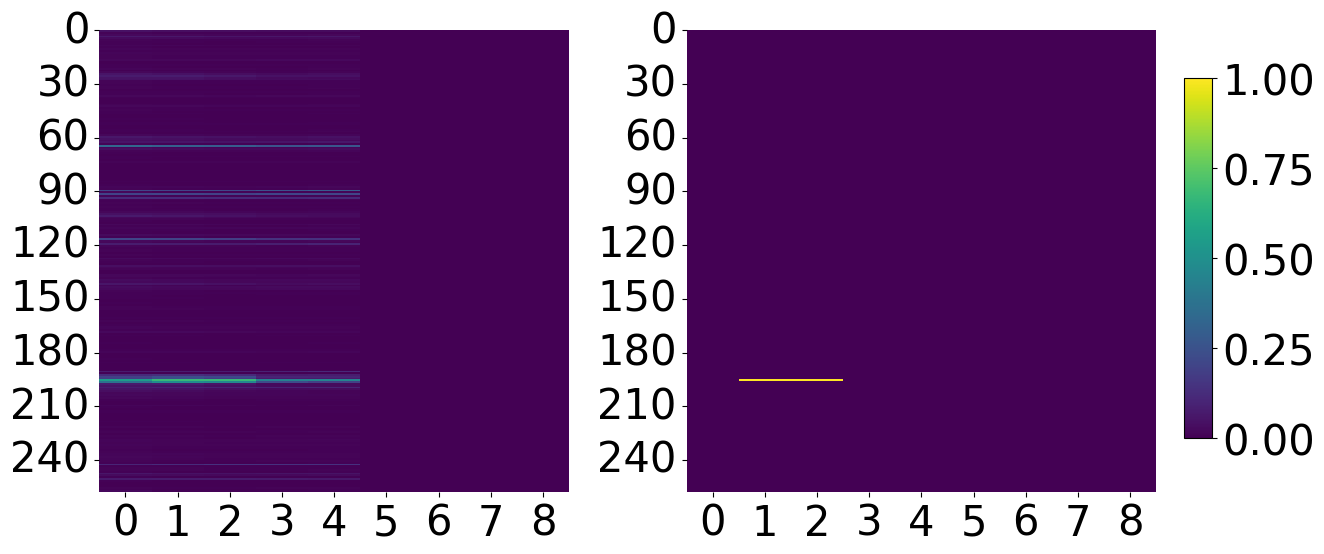

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 45,          # toàn bộ chữ mặc định = 30
    "axes.labelsize": 45,
    "axes.titlesize": 45,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "legend.fontsize": 45
})
mpl.rcParams['axes.labelweight'] = 'normal'

# --- tạo figure 2 cột ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

interaction_idx = 1
step = 30

# Heatmap bên trái: logits
sns.heatmap(
    (logits_masked)[:, :, interaction_idx].numpy(),
    vmin=0, vmax=1, ax=axes[0], cmap='viridis',
    cbar=False,
    xticklabels=True,
    yticklabels=True,
    rasterized=True   # thêm ở đây
)
# axes[0].set_title("Predicted (logits)", pad=20)
# axes[0].set_xlabel("Functional groups")
# axes[0].set_ylabel("Residues")
yticks = range(0, label.shape[0], step)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(yticks, rotation=0)

# Heatmap bên phải: label
sns.heatmap(
    label[:, :, interaction_idx].numpy(),
    vmin=0, vmax=1, ax=axes[1], cmap='viridis',
    cbar=False,
    xticklabels=True,
    yticklabels=True,
    rasterized=True   # thêm ở đây
)
# axes[1].set_title("Ground Truth", pad=20)
# axes[1].set_xlabel("Functional groups")
# axes[1].set_ylabel("")
axes[1].set_yticks(yticks)
axes[1].set_yticklabels(yticks, rotation=0)

# Thêm colorbar chung
fig.subplots_adjust(right=0.88, wspace=0.25)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cb = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis'),
    cax=cbar_ax
)
cb.ax.tick_params(labelsize=30)

if label.shape[1] > 10:
    xstep = 3
    for ax in axes:
        xticks = range(0, label.shape[1], xstep)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks, rotation=0)

plt.savefig(f"{protein_name}.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
# Min, Max, Mean over the entire tensor
print("Min:", torch.min(x).item())
print("Max:", torch.max(x).item())
print("Mean:", torch.mean(x).item())

# Along specific dimensions
print("Mean along rows (dim=1):", torch.mean(x, dim=1))
print("Mean along columns (dim=0):", torch.mean(x, dim=0))

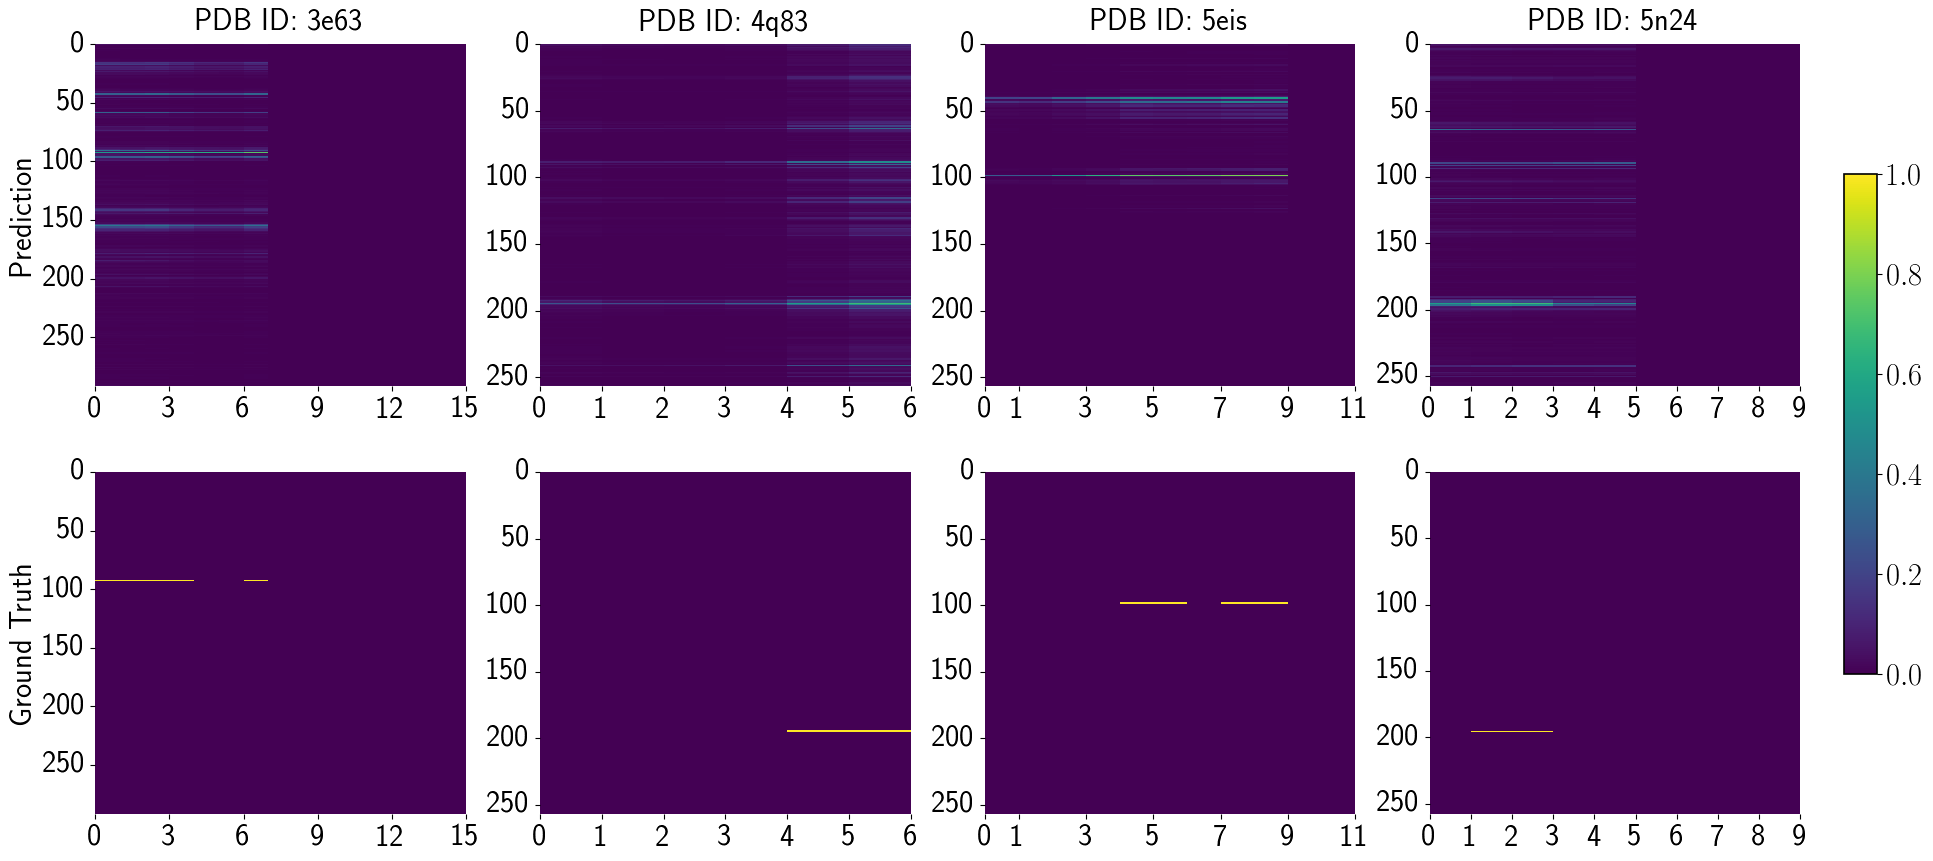

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

plt.rcParams.update({
    "figure.figsize": (6, 5),
    "text.usetex": True,             # enable LaTeX rendering
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.linewidth": 1.2,
    "font.size": 22,
    "axes.labelsize": 22,
    "axes.titlesize": 22,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 22,
})
mpl.rcParams["axes.labelweight"] = "normal"

# Example: you have 4 masked logits and 4 corresponding labels
logits_list = mask_all
labels_list = label_all
protein_names = protein_all

interaction_idx = 1
step = 50   # step size for y-axis ticks
# reduce x-axis ticks if the length is large

# Create a figure with 2 rows × 4 columns
# Each column corresponds to one protein:
#   top row    → prediction
#   bottom row → ground truth
fig, axes = plt.subplots(2, 4, figsize=(22, 10), sharex=False, sharey=False)

for i, (logits_masked, label, pname) in enumerate(
    zip(logits_list, labels_list, protein_names)
):
    # --- Prediction (top row) ---
    sns.heatmap(
        logits_masked[:, :, interaction_idx].numpy(),
        vmin=0,
        vmax=1,
        ax=axes[0, i],
        cmap="viridis",
        cbar=False,
        xticklabels=True,
        yticklabels=True,
        rasterized=True,
    )

    if i == 0:
        axes[0, i].set_ylabel("Prediction")

    yticks = range(0, label.shape[0], step)
    axes[0, i].set_yticks(yticks)
    axes[0, i].set_yticklabels(yticks, rotation=0)
    axes[0, i].set_title("PDB ID: " + pname, pad=10)

    # --- Ground Truth (bottom row) ---
    sns.heatmap(
        label[:, :, interaction_idx].numpy(),
        vmin=0,
        vmax=1,
        ax=axes[1, i],
        cmap="viridis",
        cbar=False,
        xticklabels=True,
        yticklabels=True,
        rasterized=True,
    )

    axes[1, i].set_yticks(yticks)
    axes[1, i].set_yticklabels(yticks, rotation=0)

    if i == 0:
        axes[1, i].set_ylabel("Ground Truth")

    # --- Control x-axis ticks ---
    xlen = label.shape[1]
    if pname == "3e63":
        n_ticks = 6   # desired number of ticks (including start and end)
    elif pname == "5eis":
        n_ticks = 7
    else:
        n_ticks = xlen + 1

    xticks = np.linspace(0, xlen, n_ticks, dtype=int)
    axes[0, i].set_xticks(xticks)
    axes[0, i].set_xticklabels(xticks, rotation=0)
    axes[1, i].set_xticks(xticks)
    axes[1, i].set_xticklabels(xticks, rotation=0)

# Shared colorbar
fig.subplots_adjust(right=0.9, wspace=0.2, hspace=0.25)
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cb = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), cax=cbar_ax)
cb.ax.tick_params(labelsize=22)

plt.plot()
# plt.savefig("all_proteins.png", bbox_inches="tight", dpi=300)
plt.savefig("protein_visualization.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()


In [70]:
data.keys()

dict_keys(['logits', 'label', 'mask'])

In [71]:
label.shape

torch.Size([257, 6, 7])

In [72]:
logits_masked_pred.shape

torch.Size([257])

In [73]:
(logits_masked >= 0.45).shape

torch.Size([257, 6, 7])

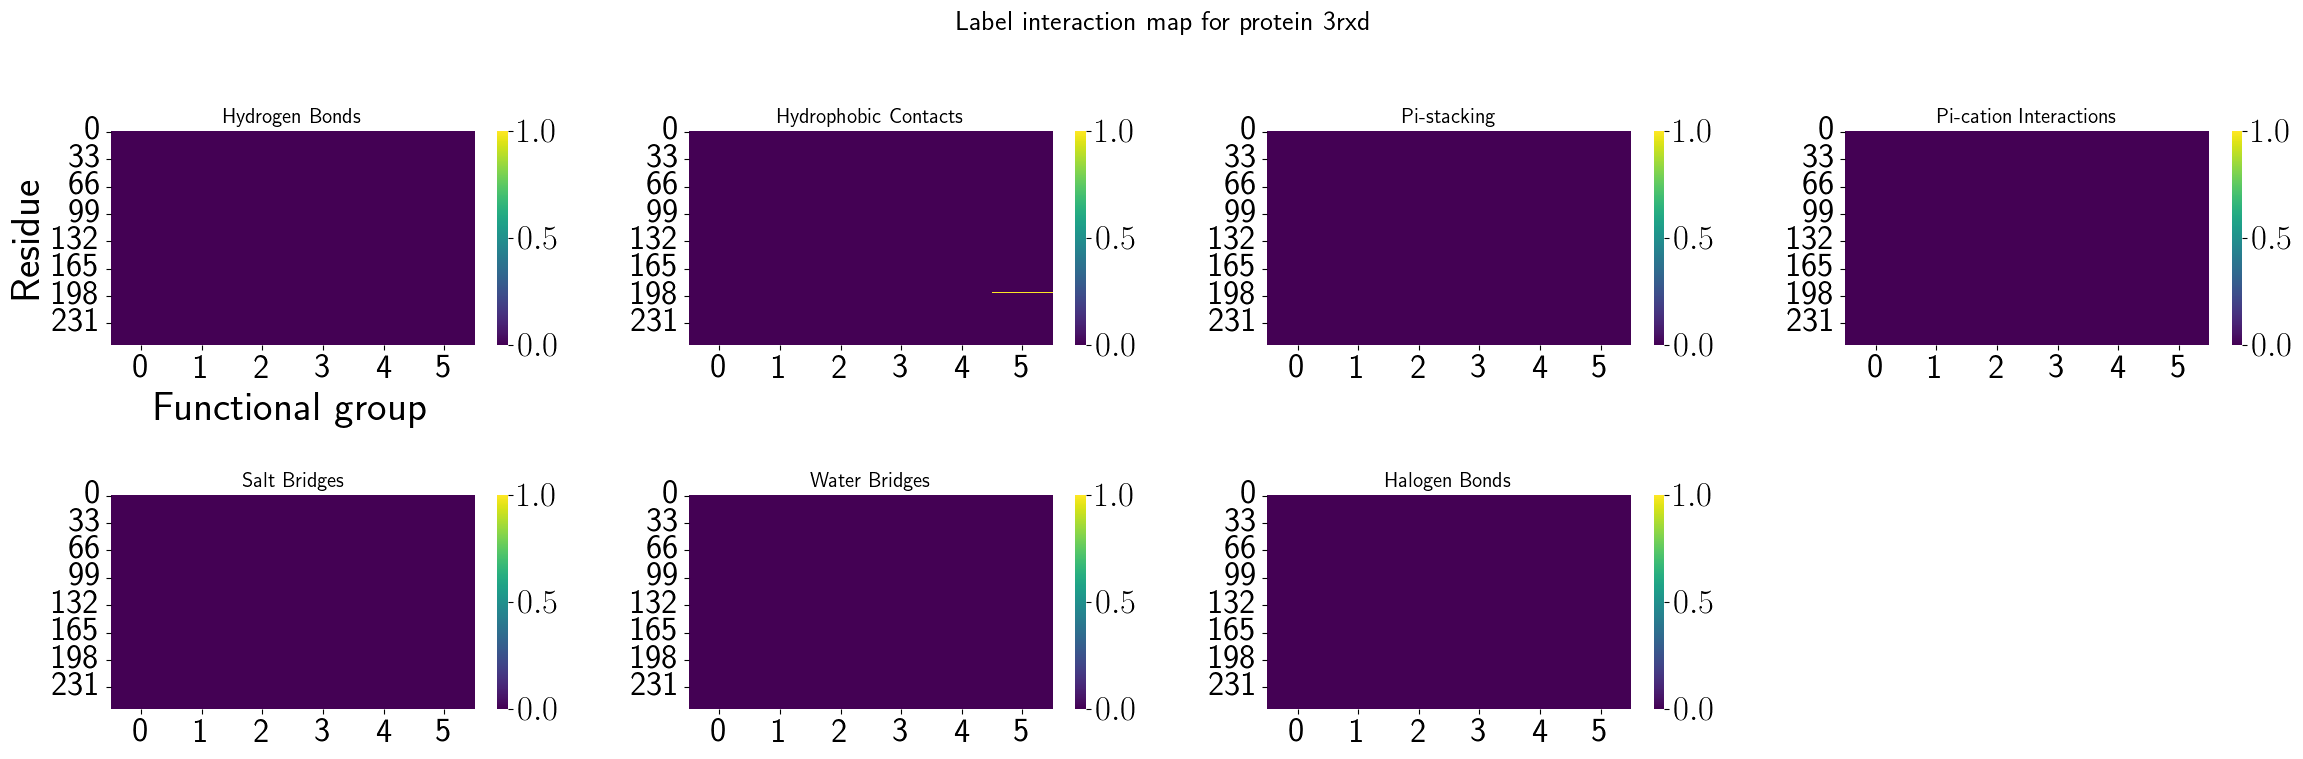

In [75]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Danh sách tên lớp
class_names = [
    "Hydrogen Bonds",
    "Hydrophobic Contacts",
    "Pi-stacking",
    "Pi-cation Interactions",
    "Salt Bridges",
    "Water Bridges",
    "Halogen Bonds"
]

# Tạo subplot: 2 hàng, tổng cộng 7 hình (3 + 4)
fig, axes = plt.subplots(2, 4, figsize=(24, 8))  # 2 rows × 4 cols = 8 slots (thừa 1 slot)

axes = axes.flatten()  # Chuyển về 1D list để dễ xử lý vòng lặp
from matplotlib.colors import ListedColormap

thres = 0.67
for i in range(7):
    sns.heatmap((logits_masked >= thres)[:, :, i].numpy(),vmin=0, vmax=1, ax=axes[i], cmap='viridis')
    axes[i].set_title(class_names[i], fontsize=15)
    if  i == 0:
        axes[i].set_xlabel("Functional group")
        axes[i].set_ylabel("Residue")

fig.suptitle(f"Label interaction map for protein {protein_name}", fontsize=20)
# Xóa ô cuối nếu không dùng (slot thứ 8)
fig.delaxes(axes[7])

plt.tight_layout()
# os.makedirs('./plots', exist_ok=True)
# plt.savefig(f"plots/Label_{protein_name}_interactions.png", bbox_inches=None)
# plt.close()
plt.show()


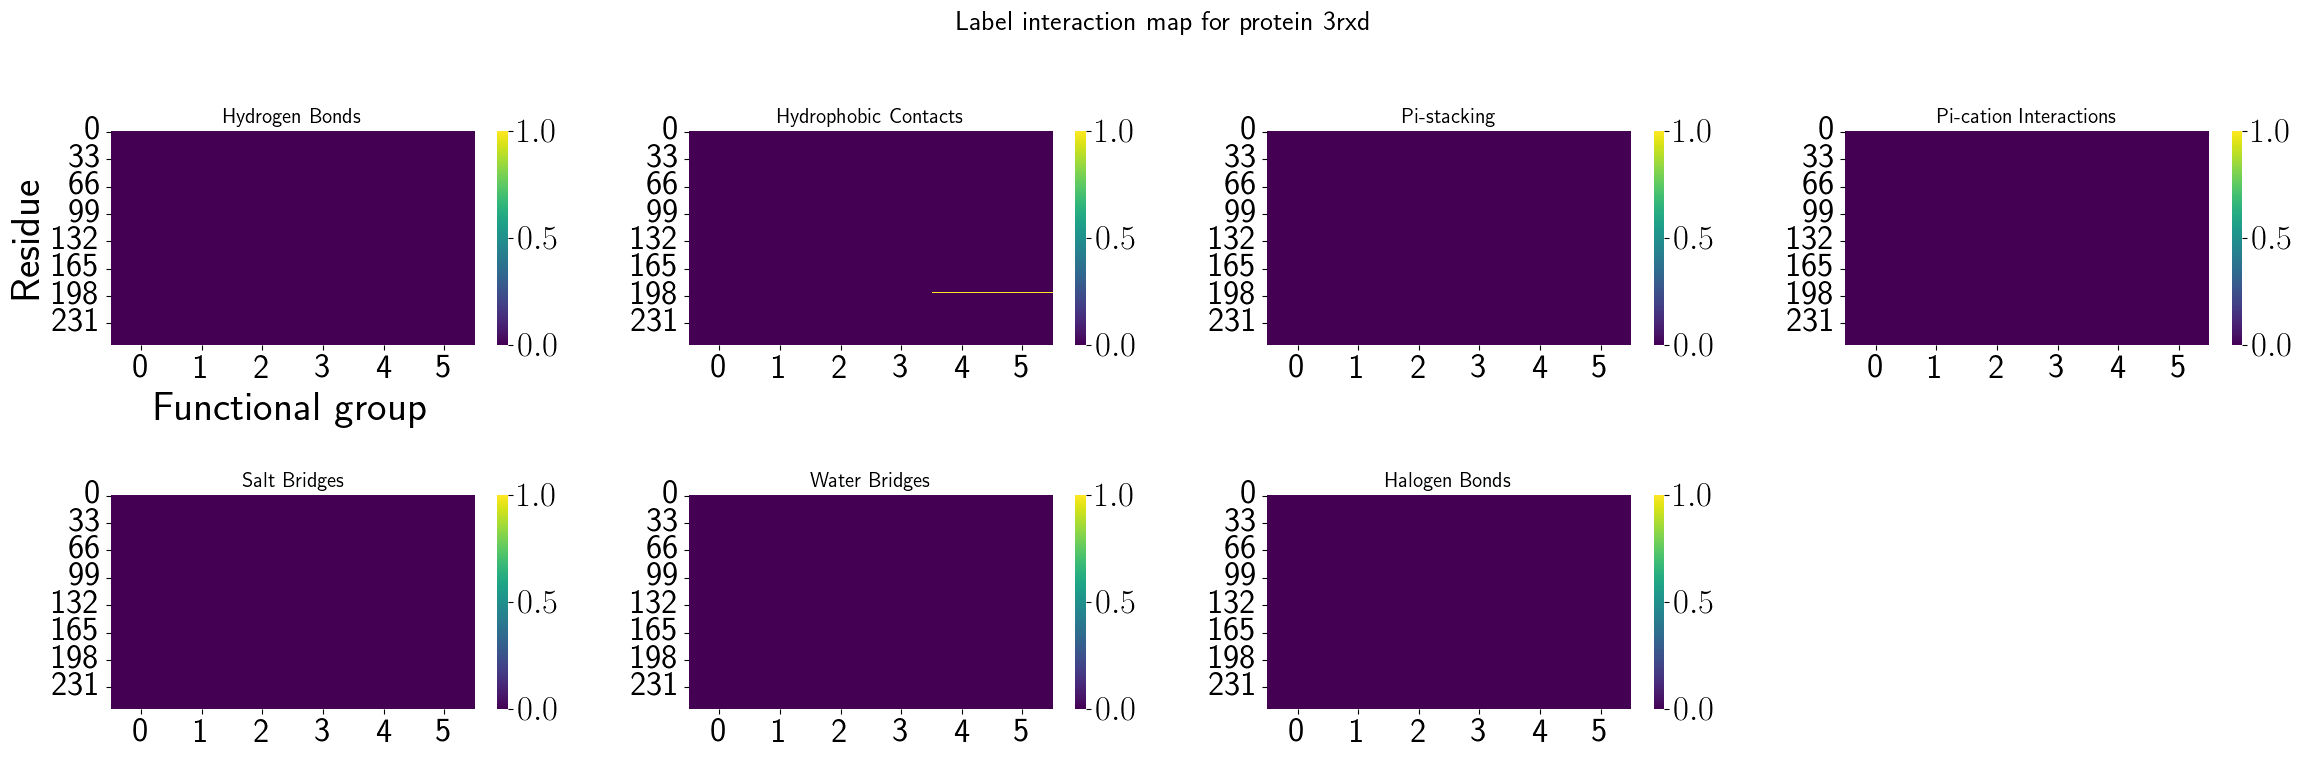

In [76]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Danh sách tên lớp
class_names = [
    "Hydrogen Bonds",
    "Hydrophobic Contacts",
    "Pi-stacking",
    "Pi-cation Interactions",
    "Salt Bridges",
    "Water Bridges",
    "Halogen Bonds"
]

# Tạo subplot: 2 hàng, tổng cộng 7 hình (3 + 4)
fig, axes = plt.subplots(2, 4, figsize=(24, 8))  # 2 rows × 4 cols = 8 slots (thừa 1 slot)

axes = axes.flatten()  # Chuyển về 1D list để dễ xử lý vòng lặp
from matplotlib.colors import ListedColormap


for i in range(7):
    sns.heatmap(label[:, :, i].numpy(),vmin=0, vmax=1, ax=axes[i], cmap='viridis')
    axes[i].set_title(class_names[i], fontsize=15)
    if  i == 0:
        axes[i].set_xlabel("Functional group")
        axes[i].set_ylabel("Residue")

fig.suptitle(f"Label interaction map for protein {protein_name}", fontsize=20)
# Xóa ô cuối nếu không dùng (slot thứ 8)
fig.delaxes(axes[7])

plt.tight_layout()
# os.makedirs('./plots', exist_ok=True)
# plt.savefig(f"plots/Label_{protein_name}_interactions.png", bbox_inches=None)
# plt.close()
plt.show()


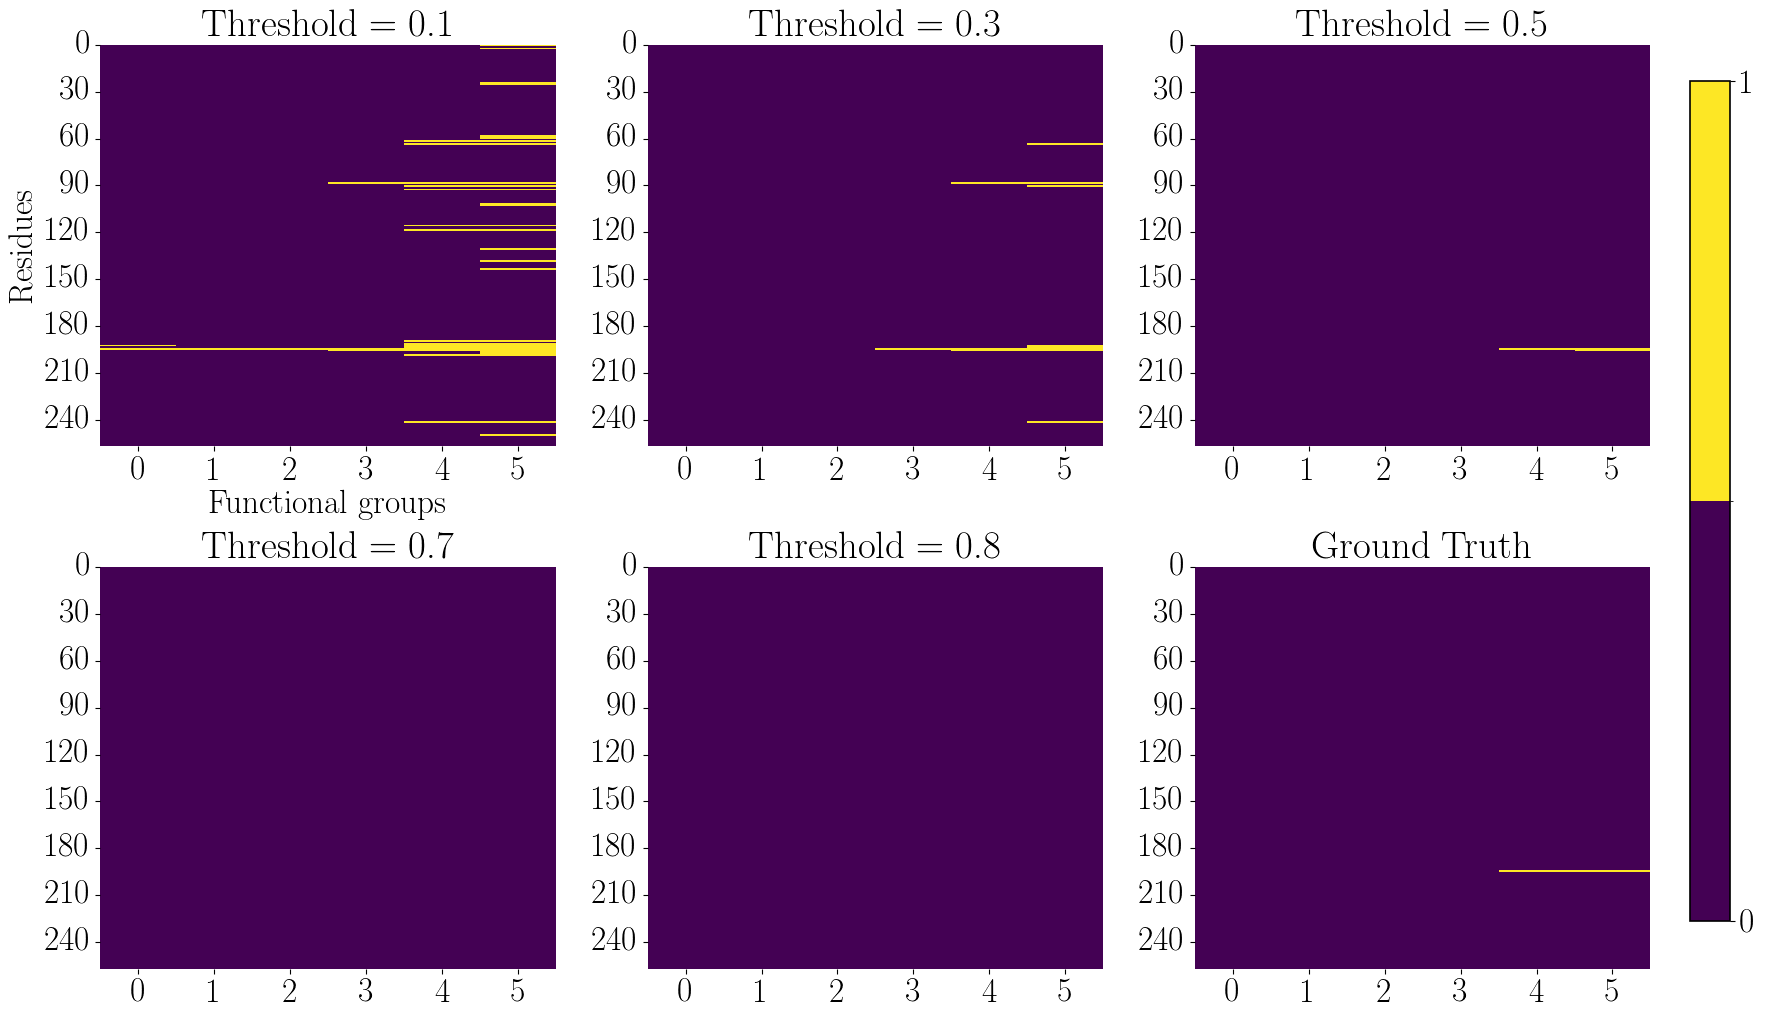

In [77]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16
})


# --- dùng LaTeX để render chữ ---
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = ['Helvetica']  # hoặc 'Arial', 'DejaVu Sans'
# mpl.rcParams['font.size'] = 14  # số lớn hơn cho đẹp
mpl.rcParams['axes.labelweight'] = 'normal'
# mpl.rcParams['axes.linewidth'] = 1.2

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

step = 30  
fontsize_ticks = 24  
thresholds = [0.1, 0.3,0.5,0.7,0.8]
interaction_idx = 1
for j, thres in enumerate(thresholds):
    hm = sns.heatmap(
        (logits_masked >= thres)[:, :, interaction_idx].numpy(),
        vmin=0, vmax=1, ax=axes[j], cmap='viridis',
        cbar=False
    )
    axes[j].set_title(f"Threshold = {thres}", fontsize=28)

    if j == 0:  
        axes[j].set_xlabel("Functional groups", fontsize=24)
        axes[j].set_ylabel("Residues", fontsize=24)
    else:
        axes[j].set_xlabel("")
        axes[j].set_ylabel("")

    axes[j].tick_params(axis='x', labelsize=fontsize_ticks)

    yticks = range(0, label.shape[0], step)
    axes[j].set_yticks(yticks)
    axes[j].set_yticklabels(yticks, fontsize=fontsize_ticks, rotation=0)

# Ground truth
last_hm = sns.heatmap(
    label[:, :, interaction_idx].numpy(),
    vmin=0, vmax=1, ax=axes[len(thresholds)], cmap='viridis',
    cbar=False
)
axes[len(thresholds)].set_title("Ground Truth", fontsize=28)

axes[len(thresholds)].tick_params(axis='x', labelsize=fontsize_ticks)
axes[len(thresholds)].tick_params(axis='y', labelsize=fontsize_ticks)

yticks = range(0, label.shape[0], step)
axes[len(thresholds)].set_yticks(yticks)
axes[len(thresholds)].set_yticklabels(yticks, fontsize=fontsize_ticks, rotation=0)

# tạo colormap 2 màu (viridis min/max)
colors = ["#440154", "#FDE725"]
cmap = ListedColormap(colors)
bounds = [0, 0.5, 1]
norm = BoundaryNorm(bounds, cmap.N)

# thêm colorbar bên phải toàn figure
fig.subplots_adjust(right=0.9, hspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    boundaries=bounds,
    ticks=[0, 1]
)
cb.ax.tick_params(labelsize=24)   # số to lên


plt.savefig("heatmap_thresholds.pdf", format="pdf", bbox_inches="tight")


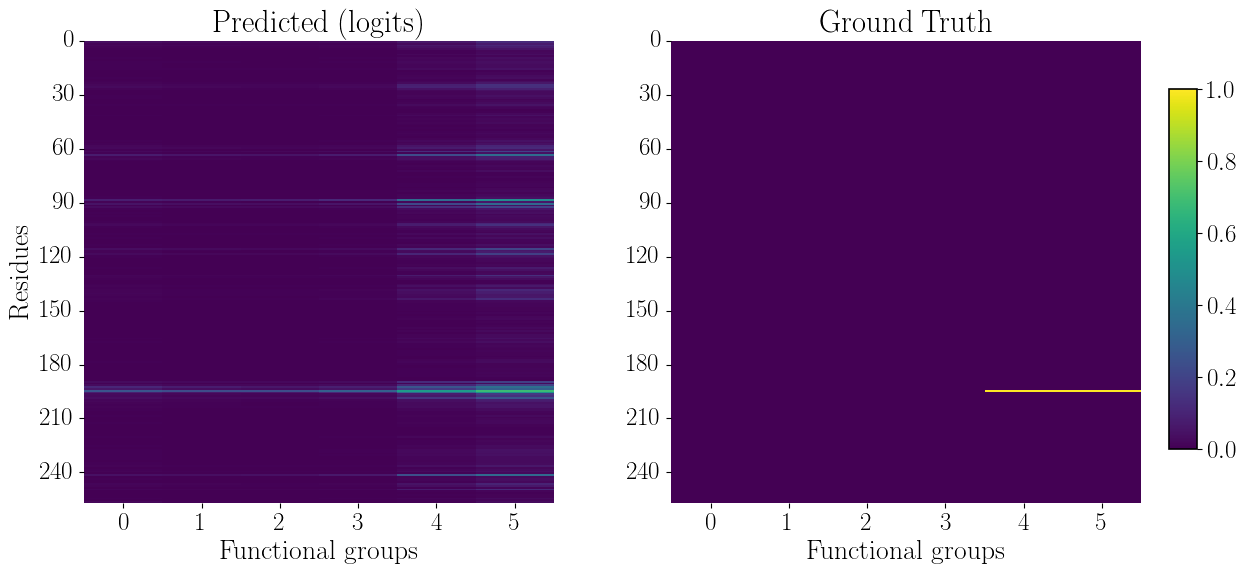

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16
})
mpl.rcParams['axes.labelweight'] = 'normal'

# --- tạo figure 2 cột ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

interaction_idx = 1
step = 30
fontsize_ticks = 18

# Heatmap bên trái: logits
sns.heatmap(
    (logits_masked)[:, :, interaction_idx].numpy(),
    vmin=0, vmax=1, ax=axes[0], cmap='viridis',
    cbar=False,
    xticklabels=True,
    yticklabels=True
)
axes[0].set_xticklabels(
    axes[0].get_xticklabels(), 
    rotation=0, ha="center", fontsize=fontsize_ticks
)
axes[0].set_title("Predicted (logits)", fontsize=22)
axes[0].set_xlabel("Functional groups", fontsize=20)
axes[0].set_ylabel("Residues", fontsize=20)
axes[0].tick_params(axis='x', labelsize=fontsize_ticks)
yticks = range(0, label.shape[0], step)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(yticks, fontsize=fontsize_ticks, rotation=0)

# Heatmap bên phải: label
# Heatmap bên phải: label
sns.heatmap(
    label[:, :, interaction_idx].numpy(),
    vmin=0, vmax=1, ax=axes[1], cmap='viridis',
    cbar=False,
    xticklabels=True,
    yticklabels=True
)
axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=0, ha="center", fontsize=fontsize_ticks
)
axes[1].set_title("Ground Truth", fontsize=22)
axes[1].set_xlabel("Functional groups", fontsize=20)
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelsize=fontsize_ticks)
axes[1].tick_params(axis='y', labelsize=fontsize_ticks)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels(yticks, fontsize=fontsize_ticks, rotation=0)


# Thêm colorbar chung
fig.subplots_adjust(right=0.88, wspace=0.25)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cb = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis'),
    cax=cbar_ax
)
cb.ax.tick_params(labelsize=fontsize_ticks)
# xstep = 5  

# for ax in axes:
#     xticks = range(0, label.shape[1], xstep)
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xticks, fontsize=fontsize_ticks, rotation=0)
plt.savefig("logits_vs_label.pdf", format="pdf", bbox_inches="tight")
plt.show()


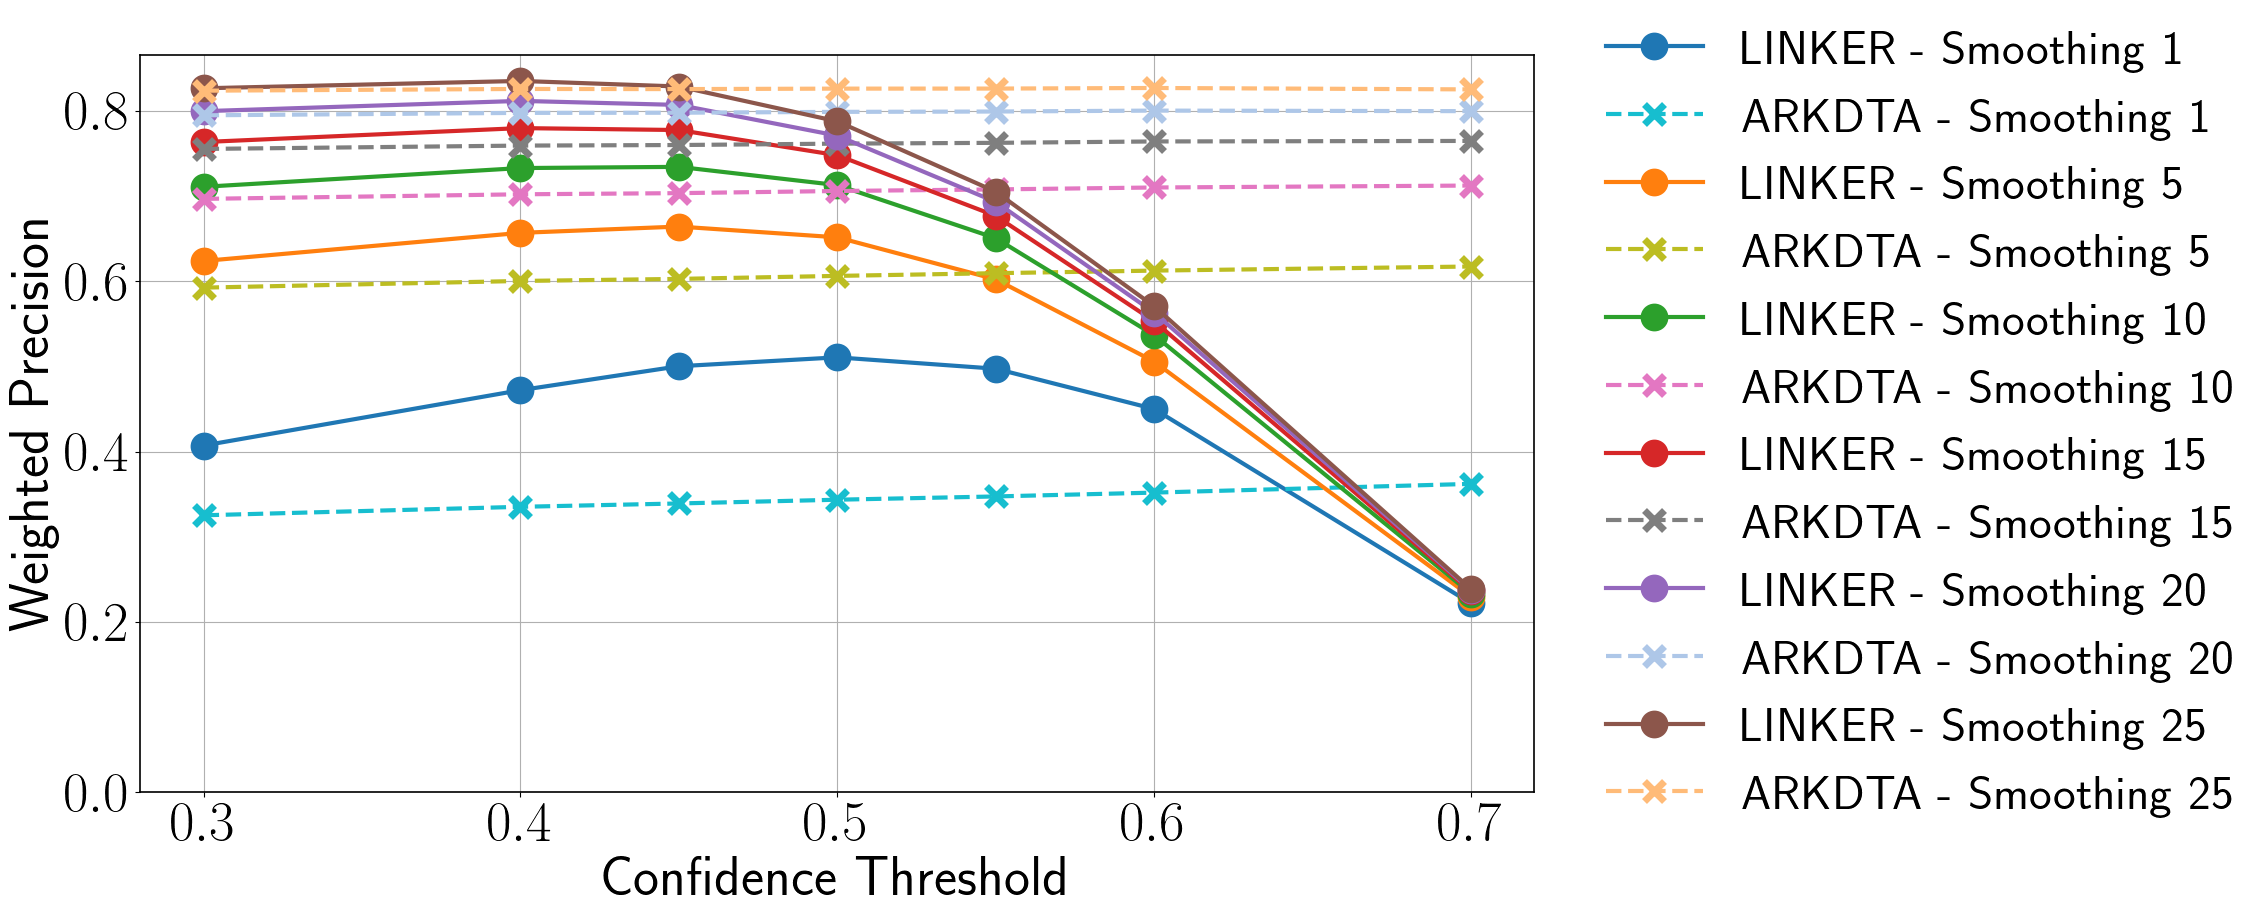

In [92]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
plt.close()             # Đóng figure hiện tại
plt.close('all') 
# --- Cấu hình font toàn cục cho matplotlib ---
mpl.rcParams.update({
    "figure.figsize": (6,5),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.linewidth": 1.2,
    "font.size": 40,
    "axes.labelsize": 40,
    "axes.titlesize": 40,
    "xtick.labelsize": 40,
    "ytick.labelsize": 40,
    "legend.fontsize": 35, 
    "font.weight": "normal"# chữ mỏng hơn (có thể dùng 'normal' hoặc 'book')
                                # Không dùng LaTeX nếu muốn font global có hiệu lực
})

smoothing_labels = ['Smoothing 1', 'Smoothing 5', 'Smoothing 10', 'Smoothing 15', 'Smoothing 20', 'Smoothing 25']
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#17becf', '#bcbd22', '#e377c2', '#7f7f7f', '#aec7e8', '#ffbb78'
]

plt.figure(figsize=(25, 10))

for i in range(6):
    plt.plot(
        [selected_conf_values_updated[j] for j in range(len(all_selected_indices_updated))],
        all_scores_updated[:, i], marker='o',
        label=f'LINKER - {smoothing_labels[i]}',
        color=colors[i], linewidth=3, markersize=15,          # tăng kích thước marker
        markeredgewidth=5,      # dày viền marker
        markerfacecolor=colors[i]  # đảm bảo fill cùng màu đường
    )
    
    if i < len(arkdta_scores_updated[0]):
        plt.plot(
            arkdta_conf_updated,
            arkdta_scores_updated[:, i], marker='x', linestyle='--',
            label=f'ARKDTA - {smoothing_labels[i]}',
            color=colors[i + 6], linewidth=3, markersize=15,          # tăng kích thước marker
        markeredgewidth=5,      # dày viền marker
        markerfacecolor=colors[i]  # đảm bảo fill cùng màu đường
        )

plt.xlabel('Confidence Threshold')
plt.ylabel('Weighted Precision')

plt.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
# plt.xlim(left=0)   # ép trục X bắt đầu từ 0
plt.ylim(bottom=0) # ép trục Y bắt đầu từ 0

plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.95, 1])
# ax = plt.gca()
# ax.spines['left'].set_position('zero')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# Lưu PDF
plt.savefig("smooth_label_analysis.pdf", format='pdf', bbox_inches='tight', dpi=600)

plt.show()


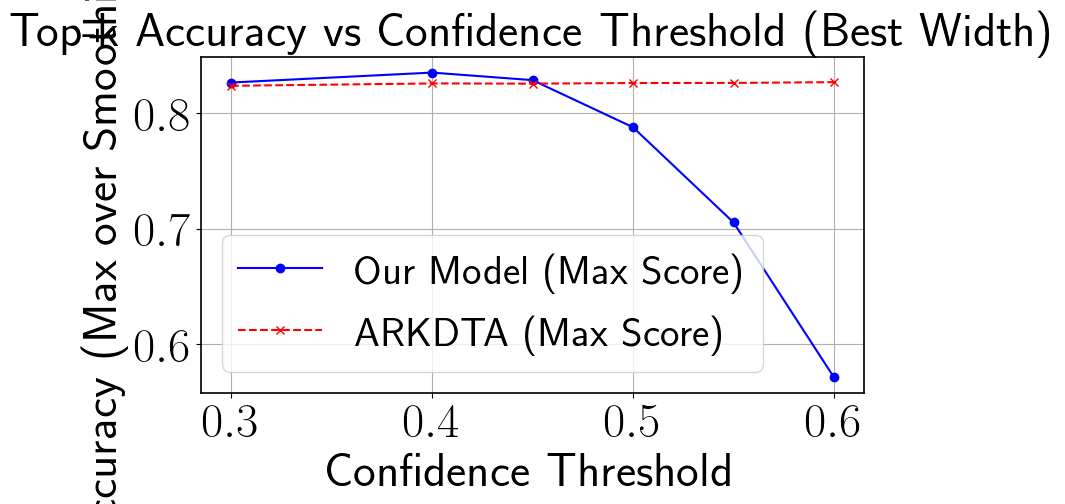

In [97]:
# Extract updated scores based on selected smoothing widths and confidence thresholds
all_scores_updated = all_scores_np[all_selected_indices_updated]
arkdta_scores_updated = arkdta_scores_np[arkdta_selected_indices_updated]

# Get the maximum score at each confidence threshold for both models
all_max_scores = all_scores_updated.max(axis=1)
arkdta_max_scores = arkdta_scores_updated.max(axis=1)

# Prepare updated confidence thresholds for plotting
arkdta_conf_updated = [arkdta_conf_values[i] for i in arkdta_selected_indices_updated]

# Plot the max score curves
plt.figure(figsize=(8, 5))

plt.plot(selected_conf_values_updated, all_max_scores, marker='o', color='blue', label='Our Model (Max Score)')
plt.plot(arkdta_conf_updated, arkdta_max_scores, marker='x', color='red', linestyle='--', label='ARKDTA (Max Score)')

plt.xlabel('Confidence Threshold')
plt.ylabel('Top-k Accuracy (Max over Smoothing Widths)')
plt.title('Top-k Accuracy vs Confidence Threshold (Best Width)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from glob import glob
protein_names = list(set([os.path.split(x)[1].split('.')[0] for x in glob('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/predictions/*')]))

near_residue_list = [1, 5, 10, 15, 20, 25]
num_near = len(near_residue_list)

# Khởi tạo mảng kết quả
all_scores_array = np.zeros(num_near)
arkdta_scores_array = np.zeros(num_near)
count_valid = np.zeros(num_near)

def cos_sim(a,b):
    p1 = a.flatten()
    p2 = b.flatten()
    cos_sim = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
    return cos_sim
for i in range(len(protein_names)):
    protein_name = protein_names[i]
    if protein_name != '3f0r':
        continue
    data = torch.load(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/predictions_graph/{protein_name}.pt')
    logits, label, mask = data['logits'], data['label'], data['mask']
    arkdta_predict_pocket = np.load(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/reference/ArkDTA/arkdta_attention/pretrained_attention_logits/{protein_name}.npy').T
    b = (arkdta_predict_pocket[1:,:-1] > 0.5).T

    # Step 1: Reduce mask from (10, 889) → (889,)
    mask_agg = mask.max(0)[0].cpu().numpy()  # keep residues that are in any FG

    # Step 2: Prepare a and c
    a = (torch.sigmoid(logits) > 0.5).sum(2).sum(0).reshape(-1) > 0  # shape: (889,)
    c = label.sum(2).sum(0).reshape(-1) > 0                          # shape: (889,)

    # Step 3: Convert to numpy and mask
    a_masked = a.cpu().numpy().astype(np.uint8)[mask_agg == 1].reshape(-1,1)
    c_masked = c.cpu().numpy().astype(np.uint8)[mask_agg == 1].reshape(-1,1)

    # Step 4: Compute cosine similarity
    similarity = cos_sim(a_masked, c_masked)
    print(f'Masked Cosine Similarity = {similarity:.3f}')
    break

Masked Cosine Similarity = 0.707


In [14]:
logits.shape

torch.Size([10, 889, 7])

In [15]:
label.shape

torch.Size([10, 889, 7])

In [16]:
mask.shape

torch.Size([10, 889])

In [17]:
logits

tensor([[[ -5.7640,  -5.1155,  -4.7150,  ...,  -5.9725,  -6.9762, -10.3713],
         [ -5.8214,  -7.0613,  -6.3741,  ...,  -7.2154,  -8.5576, -13.6790],
         [ -5.5073,  -7.5413,  -6.5252,  ...,  -6.9762,  -8.5300, -14.1473],
         ...,
         [ -2.9770,  -3.2265,  -3.1810,  ...,  -3.6736,  -4.6100,  -7.4153],
         [ -2.5921,  -2.8056,  -2.8732,  ...,  -3.3682,  -4.1825,  -6.5124],
         [ -1.7368,  -1.8559,  -1.8230,  ...,  -2.0803,  -2.6574,  -3.9029]],

        [[ -6.8149,  -5.8398,  -5.8327,  ...,  -7.8393,  -8.9638, -14.2328],
         [ -6.3070,  -7.4446,  -7.3975,  ...,  -8.8769,  -9.6592, -17.3910],
         [ -6.1063,  -7.9854,  -7.4277,  ...,  -8.1072,  -9.3617, -17.5953],
         ...,
         [ -3.1421,  -3.1290,  -3.3223,  ...,  -4.5281,  -4.9378,  -8.8234],
         [ -2.7265,  -2.8495,  -3.0333,  ...,  -4.2790,  -4.5987,  -7.8958],
         [ -2.0469,  -2.0690,  -2.0628,  ...,  -2.8762,  -3.1081,  -4.8797]],

        [[ -7.2038,  -5.6169,  -5.4449,  ...

In [18]:
arkdta_predict_pocket.shape

(2, 365)

In [19]:
protein_name

'3f0r'

In [20]:
b.shape

(364, 1)

In [21]:
logits.shape

torch.Size([10, 889, 7])

In [24]:
label.sum(1).shape

torch.Size([10, 7])

In [59]:

def smooth_gt_no_sum(gt_hard: np.ndarray, sigma: float = 1.0, method: str = 'max') -> np.ndarray:
    """
    Smooth ground truth (N, 1) dạng numpy array bằng Gaussian từng đỉnh, không cộng dồn.

    Args:
        gt_hard (np.ndarray): Nhị phân 0/1 với shape (N, 1)
        sigma (float): Độ rộng Gaussian
        method (str): 'max' hoặc 'mean' để kết hợp

    Returns:
        np.ndarray: Smoothed ground truth (N, 1)
    """
    assert gt_hard.ndim == 2 and gt_hard.shape[1] == 1, "gt_hard phải có shape (N, 1)"
    N = gt_hard.shape[0]
    positions = np.arange(N)

    smoothed_all = []

    peak_indices = np.where(gt_hard.squeeze() == 1)[0]

    for center in peak_indices:
        gauss = np.exp(-0.5 * ((positions - center) / sigma)**2)
        smoothed_all.append(gauss.reshape(N, 1))

    if len(smoothed_all) == 0:
        return np.full((N, 1), -0.5)

    smoothed_stack = np.stack(smoothed_all, axis=2)  # (N, 1, num_peaks)

    if method == 'max':
        smoothed_gt = smoothed_stack.max(axis=2)
    elif method == 'mean':
        smoothed_gt = smoothed_stack.mean(axis=2)
    else:
        raise ValueError("method must be 'max' hoặc 'mean'")

    # smoothed_gt[smoothed_gt < 0] = 0
    return smoothed_gt

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
from glob import glob


def smooth_gt_no_sum(gt_hard: np.ndarray, sigma: float = 1.0, method: str = 'max') -> np.ndarray:
    """
    Smooth ground truth (N, 1) dạng numpy array bằng Gaussian từng đỉnh, không cộng dồn.

    Args:
        gt_hard (np.ndarray): Nhị phân 0/1 với shape (N, 1)
        sigma (float): Độ rộng Gaussian
        method (str): 'max' hoặc 'mean' để kết hợp

    Returns:
        np.ndarray: Smoothed ground truth (N, 1)
    """
    assert gt_hard.ndim == 2 and gt_hard.shape[1] == 1, "gt_hard phải có shape (N, 1)"
    N = gt_hard.shape[0]
    positions = np.arange(N)

    smoothed_all = []

    peak_indices = np.where(gt_hard.squeeze() == 1)[0]

    for center in peak_indices:
        gauss = np.exp(-0.5 * ((positions - center) / sigma)**2)
        smoothed_all.append(gauss.reshape(N, 1))

    if len(smoothed_all) == 0:
        return np.full((N, 1), -0.5)

    smoothed_stack = np.stack(smoothed_all, axis=2)  # (N, 1, num_peaks)

    if method == 'max':
        smoothed_gt = smoothed_stack.max(axis=2)
    elif method == 'mean':
        smoothed_gt = smoothed_stack.mean(axis=2)
    else:
        raise ValueError("method must be 'max' hoặc 'mean'")

    # smoothed_gt[smoothed_gt < 0] = 0
    return smoothed_gt
label_test = c_masked
smooth_label = smooth_gt_no_sum(label_test,1, 'max')

In [61]:
smooth_label.shape

(364, 1)

In [62]:
label_test.shape

(364, 1)

In [63]:
smooth_label

array([[0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00

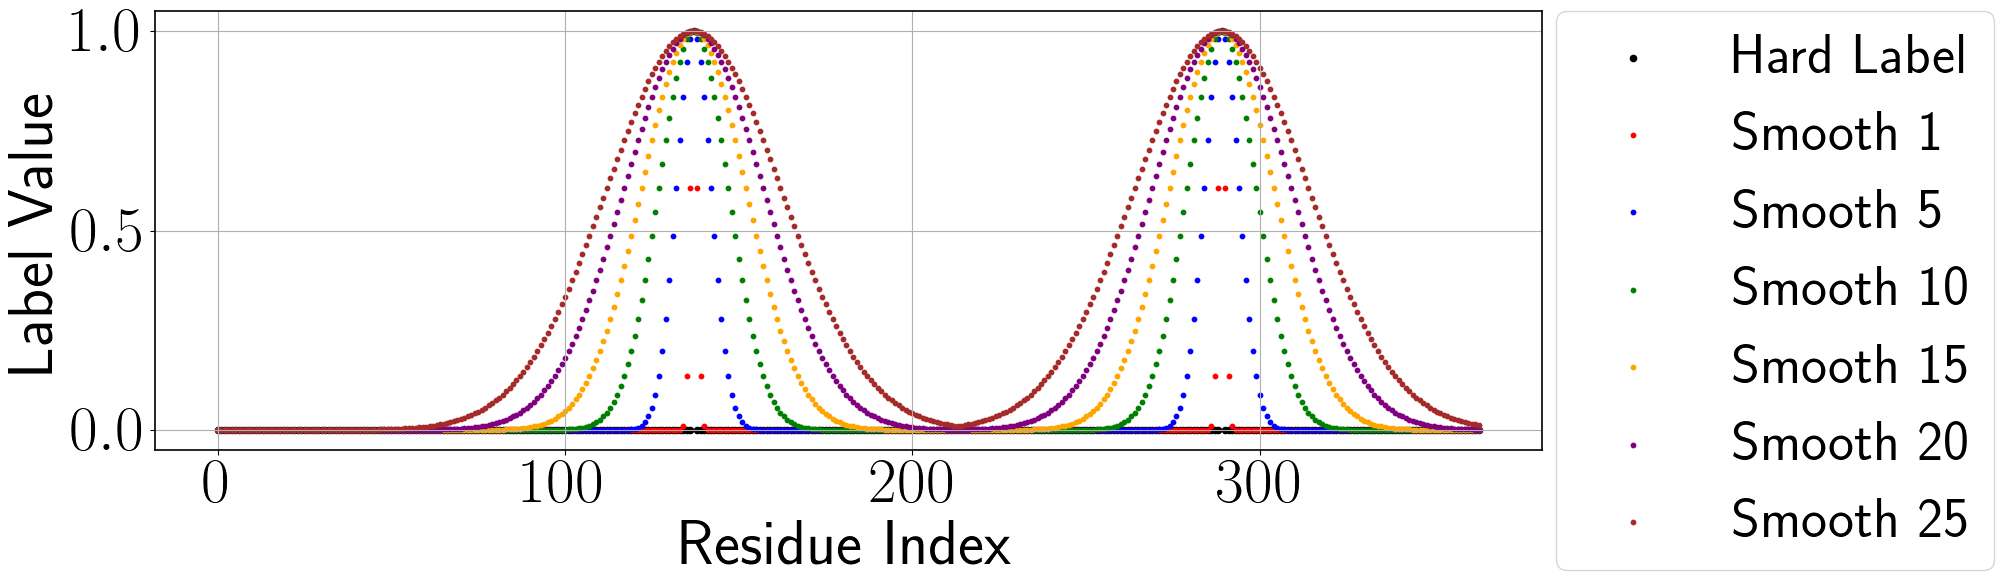

In [64]:
import matplotlib.pyplot as plt

# Cài đặt font và cỡ chữ
plt.rcParams.update({
    "figure.figsize": (25, 7),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.linewidth": 1.2 ,
    "font.size": 45,
    "axes.labelsize": 45,
    "axes.titlesize": 45,
    "xtick.labelsize": 45,
    "ytick.labelsize": 45,
    "legend.fontsize": 40
})

# Giả sử label_test có shape (N, 1), smooth_gt_no_sum trả về (N, 1) binary
smoothing_widths = [1, 5, 10, 15, 20, 25]
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown']
labels = ['Hard Label'] + [f'Smooth {w}' for w in smoothing_widths]

plt.figure(figsize=(25, 7))

# Vẽ hard label trước
plt.scatter(range(len(label_test)), label_test, color=colors[0], label=labels[0], s=20)  # tăng size điểm

# Vẽ các smoothing levels
for idx, w in enumerate(smoothing_widths):
    smoothed = smooth_gt_no_sum(label_test, w, 'max')
    plt.scatter(range(len(smoothed)), smoothed, color=colors[idx + 1], label=labels[idx + 1], s=10)

# plt.title('Comparison of Hard and Smoothed Labels')
plt.xlabel('Residue Index')
plt.ylabel('Label Value')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True)

# Lưu PDF
plt.savefig("label_comparison_font.pdf", format='pdf', bbox_inches='tight', dpi = 600)
plt.show()


/scratch/local/ipykernel_19664/73837909.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


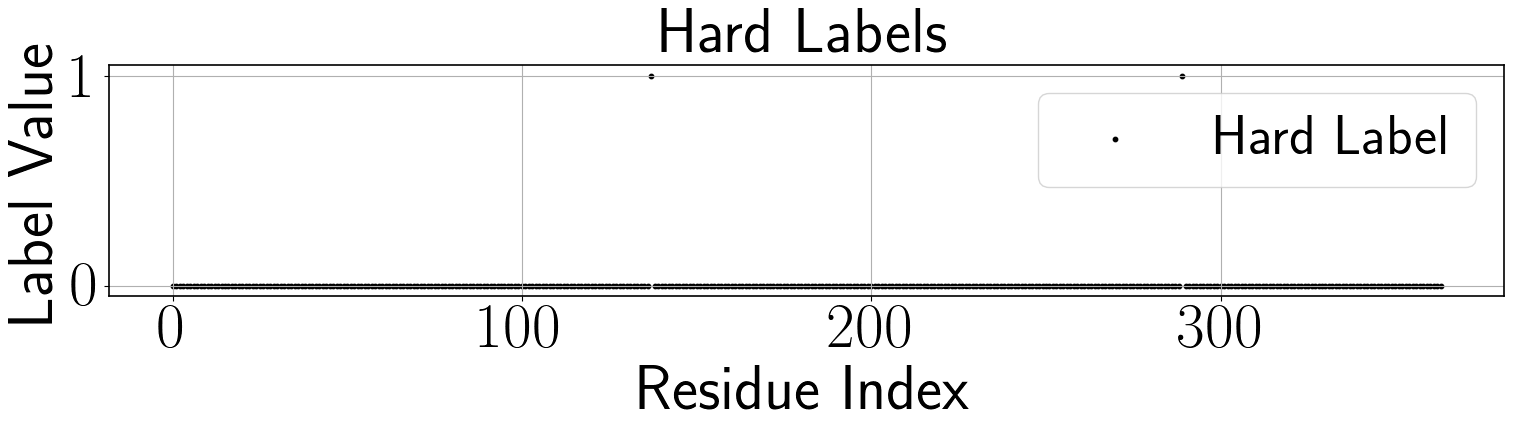

/scratch/local/ipykernel_19664/73837909.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


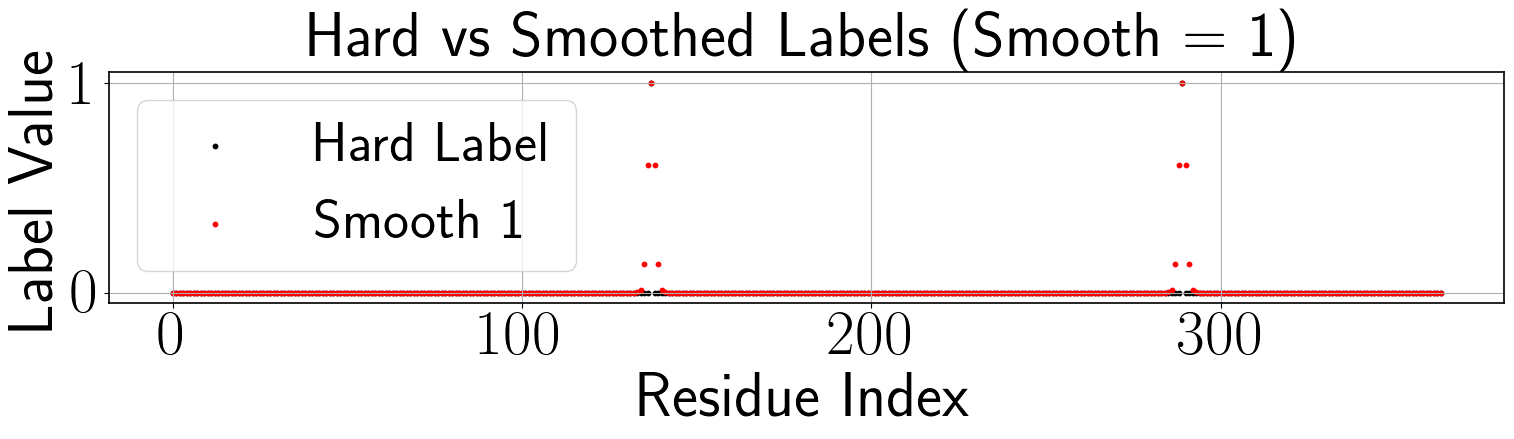

/scratch/local/ipykernel_19664/73837909.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


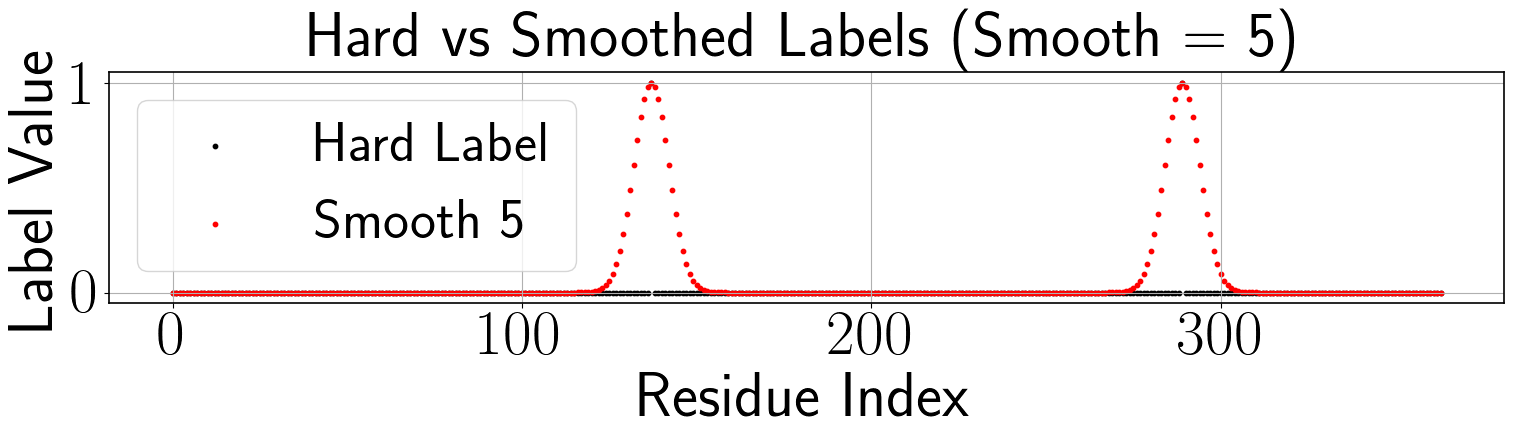

/scratch/local/ipykernel_19664/73837909.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


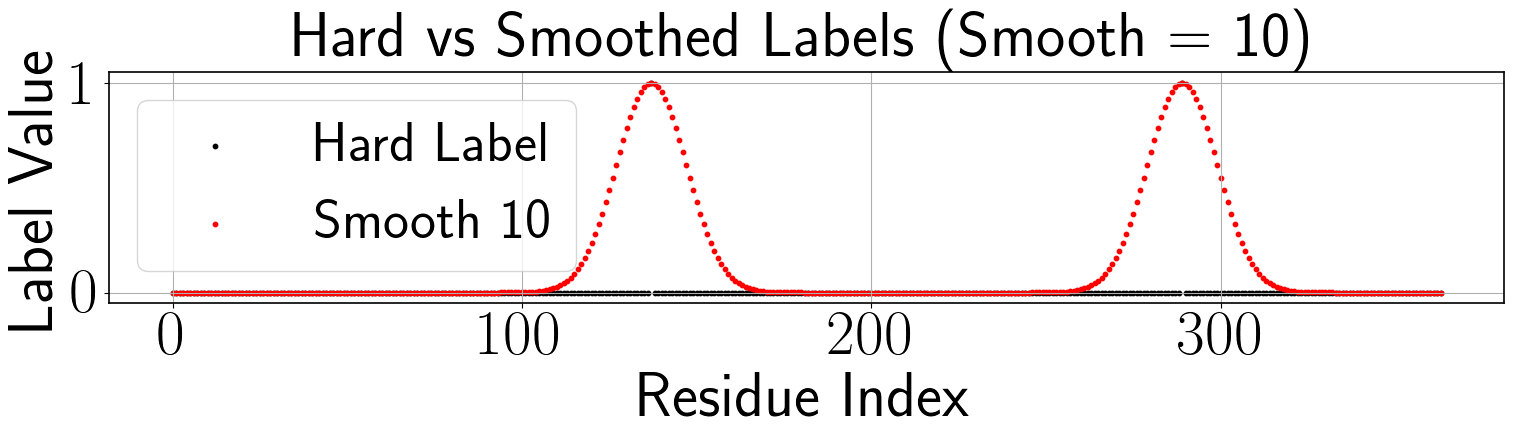

/scratch/local/ipykernel_19664/73837909.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


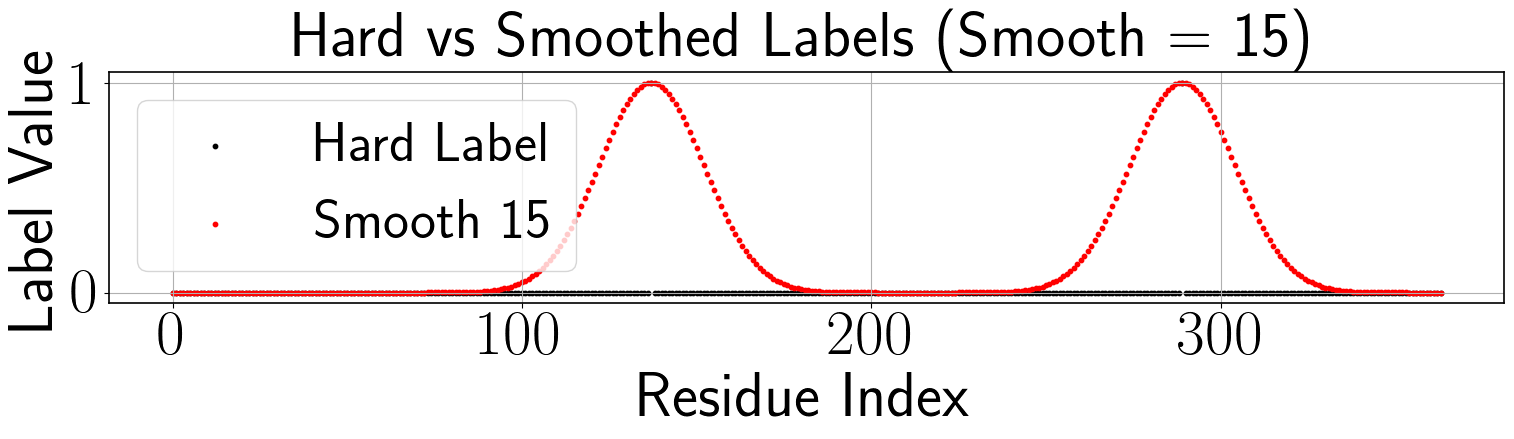

/scratch/local/ipykernel_19664/73837909.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


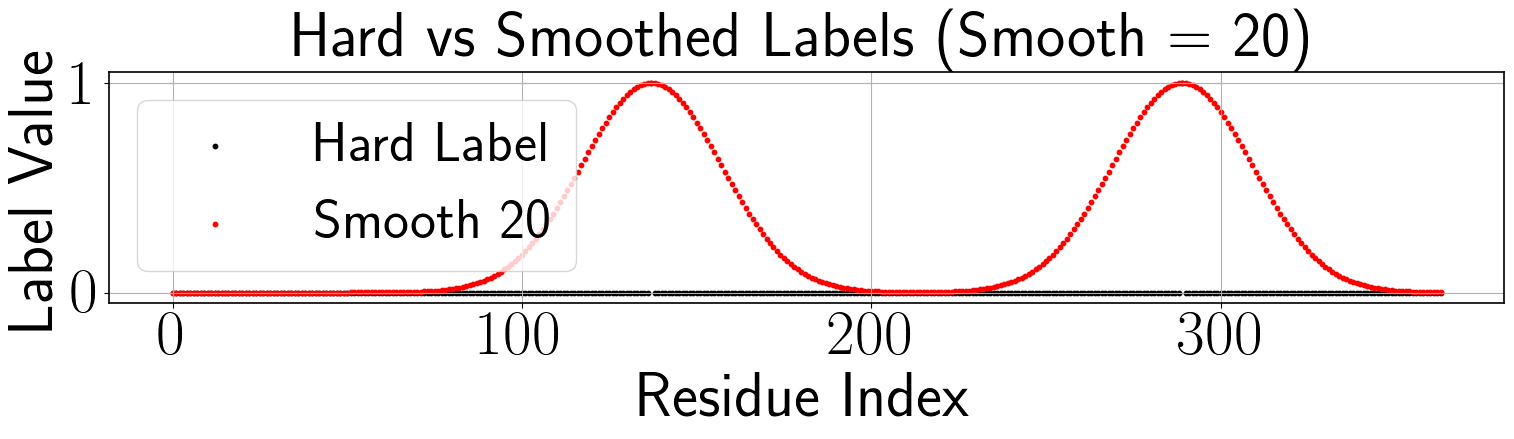

/scratch/local/ipykernel_19664/73837909.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


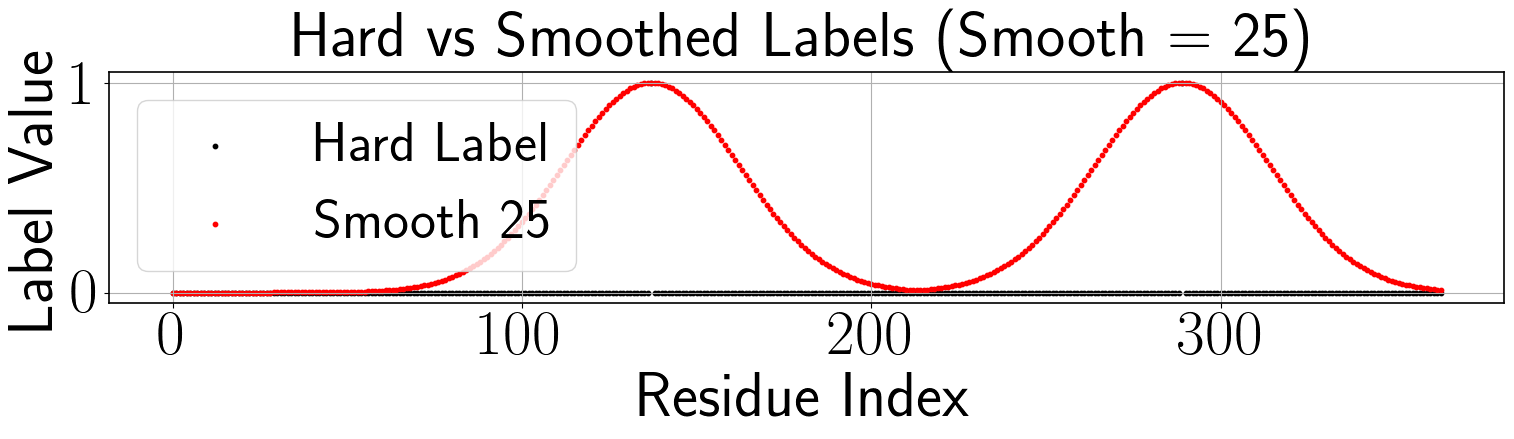

In [65]:
import matplotlib.pyplot as plt

# Giả sử label_test là (N, 1)
smoothing_widths = [1, 5, 10, 15, 20, 25]


label_test
plt.figure(figsize=(18, 3))
plt.scatter(range(len(label_test)), label_test, color='black', label='Hard Label', s=10)
plt.title(f'Hard Labels')
plt.xlabel('Residue Index')
plt.ylabel('Label Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


for w in smoothing_widths:
    smooth_label = smooth_gt_no_sum(label_test, w, 'max')

    plt.figure(figsize=(18, 3))
    plt.scatter(range(len(label_test)), label_test, color='black', label='Hard Label', s=10)
    plt.scatter(range(len(smooth_label)), smooth_label, color='red', label=f'Smooth {w}', s=10)

    plt.title(f'Hard vs Smoothed Labels (Smooth = {w})')
    plt.xlabel('Residue Index')
    plt.ylabel('Label Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


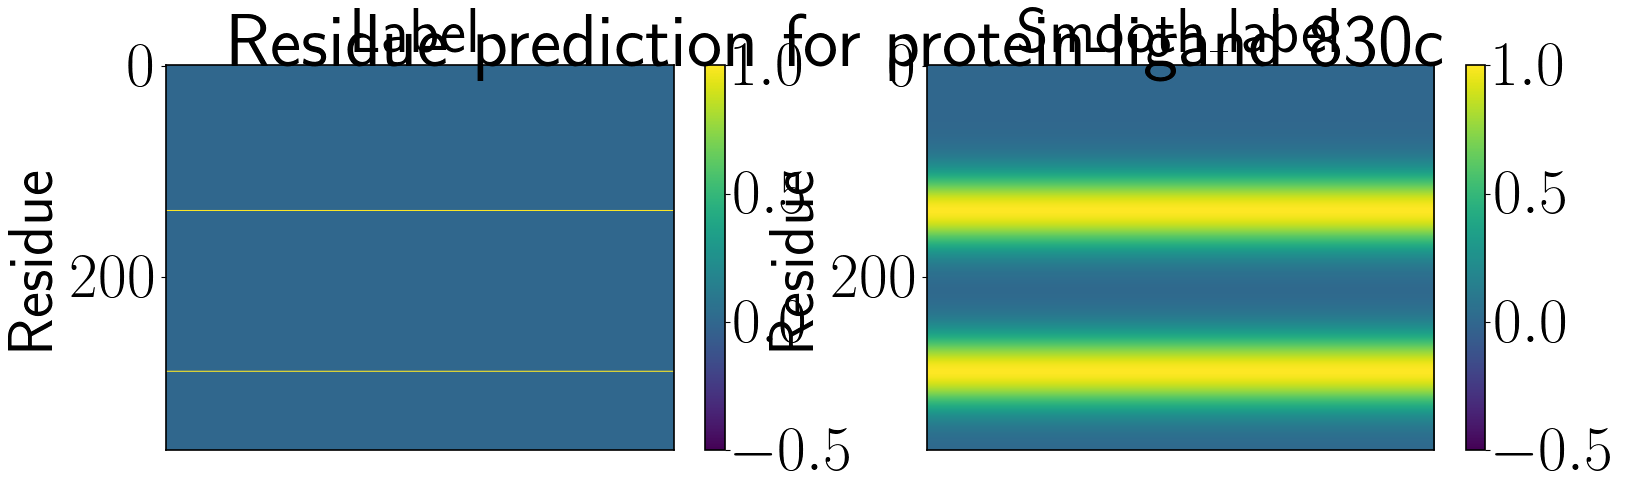

In [66]:
# Re-import required libraries after kernel reset
import matplotlib.pyplot as plt
import numpy as np
# Plot the matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # Horizontal layout

titles = ['Label', 'Smooth_label']
mats = [label_test, smooth_label]

for ax, mat, title in zip(axes, mats, titles):
    im = ax.imshow(mat, aspect='auto', cmap='viridis', vmin=-0.5, vmax=1)
    ax.set_title(title)
    ax.set_ylabel('Residue')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    fig.colorbar(im, ax=ax)

fig.suptitle(f'Residue prediction for protein-ligand {protein_name}')
plt.show()


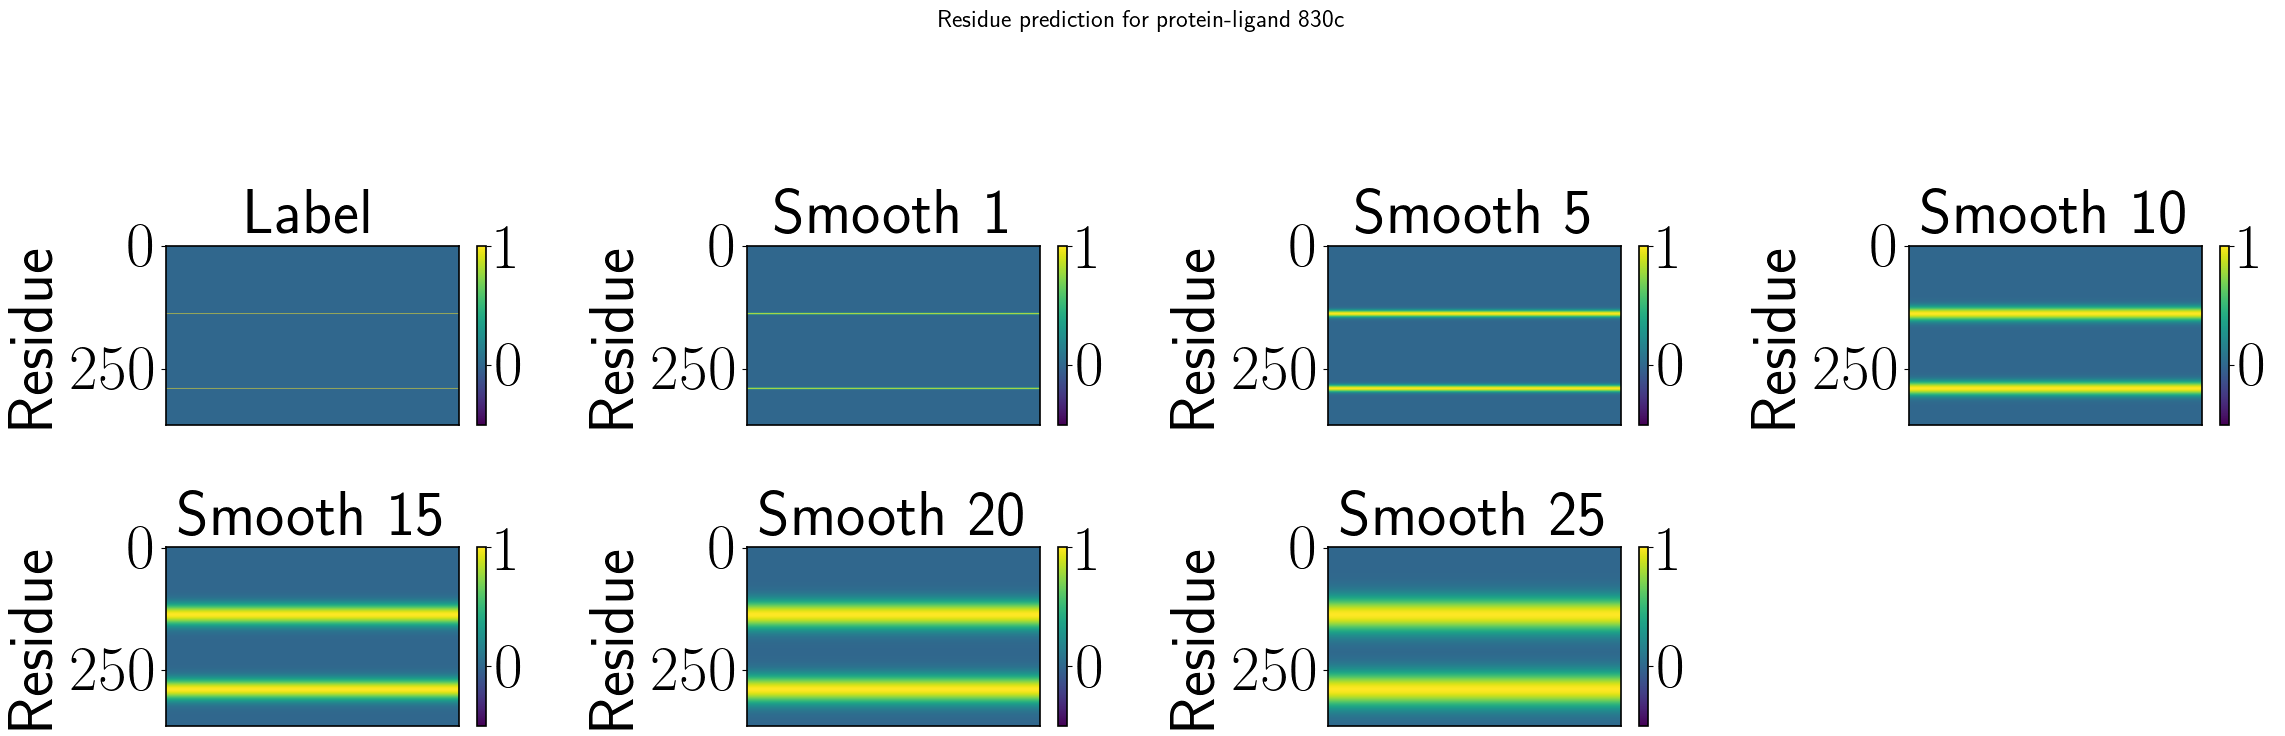

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define smoothing widths
smoothing_widths = [1, 5, 10, 15, 20, 25]

# Prepare all matrices: original + smoothed
mats = [label_test]
titles = ['Label']

for w in smoothing_widths:
    smoothed = smooth_gt_no_sum(label_test, w, 'max')
    mats.append(smoothed)
    titles.append(f'Smooth {w}')

# Plot all heatmaps in 2 rows (4 in row 1, 3 in row 2)
fig, axes = plt.subplots(2, 4, figsize=(24, 8))  # Bigger figure

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each heatmap
for i, (mat, title) in enumerate(zip(mats, titles)):
    im = axes[i].imshow(mat, aspect='auto', cmap='viridis', vmin=-0.5, vmax=1)
    axes[i].set_title(title)
    axes[i].set_ylabel('Residue')
    axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    fig.colorbar(im, ax=axes[i])

# Turn off unused subplot (the 8th slot)
if len(mats) < len(axes):
    for j in range(len(mats), len(axes)):
        axes[j].axis('off')

# Final layout
fig.suptitle(f'Residue prediction for protein-ligand {protein_name}', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [68]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from glob import glob
import torch
import os
import pickle
paths = glob('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/model/best_plip_graph_model_bindingdb_clean/*.pt')


all_y_true = []
all_y_score = []
roc_list, pr_list = [], []

for path in paths:  
    data = torch.load(path)
    prot_name = os.path.split(path)[1].split('.')[0]
    labels = torch.load(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/data/BindingDB_Feature/label/{prot_name}.pt')
    preds = torch.sigmoid(data['logits'])
    masks = data['mask'].unsqueeze(-1).repeat(1, 1, 7)
    preds = preds[masks == 1]
    labels = labels.reshape(-1) 
    if labels.shape != preds.shape:
        print('wrong')
        break
    # mỗi sample có shape khác nhau
    y_true_i = labels.reshape(-1)      # flatten
    y_score_i = preds.reshape(-1)      # flatten
    if y_true_i.sum() == 0:
        continue
    all_y_true.append(y_true_i)
    all_y_score.append(y_score_i)
    fpr, tpr, _ = roc_curve(y_true_i, y_score_i)
    roc_auc_i = auc(fpr, tpr)
    aupr_i = average_precision_score(y_true_i, y_score_i)

    roc_list.append(roc_auc_i)
    pr_list.append(aupr_i)

roc_macro = np.mean(roc_list)
aupr_macro = np.mean(pr_list)

print(f"ROC-AUC (macro): {roc_macro:.3f}")
print(f"AUPR (macro):   {aupr_macro:.3f}")

# nối thành 1 vector lớn (micro-average)
y_true = np.concatenate(all_y_true, axis=0)
y_score = np.concatenate(all_y_score, axis=0)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_true, y_score)
aupr = average_precision_score(y_true, y_score)

print(f"ROC-AUC (micro): {roc_auc:.3f}")
print(f"AUPR (micro):   {aupr:.3f}")

import pickle

# Chuẩn bị dữ liệu cần lưu
metrics_data = {
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc,
    "precision": precision,
    "recall": recall,
    "aupr": aupr,
    "y_true": y_true,
    "y_score": y_score,
    "roc_macro": roc_macro,
    "aupr_macro": aupr_macro
}

# Lưu vào file pickle
with open("metrics_micro_synthesis.pkl", "wb") as f:
    pickle.dump(metrics_data, f)




ROC-AUC (macro): 0.968
AUPR (macro):   0.123
ROC-AUC (micro): 0.963
AUPR (micro):   0.070


In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Cài đặt font và cỡ chữ
plt.rcParams.update({
    "font.family": 'sans-serif',  # toàn bộ chữ đều dùng DejaVu Sans
    "font.size": 5,
    "axes.labelsize": 25,
    "axes.titlesize": 25,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "legend.fontsize": 25
})
# Load file pickle
with open("metrics_micro_synthesis.pkl", "rb") as f:
    metrics_data = pickle.load(f)

fpr = metrics_data["fpr"]
tpr = metrics_data["tpr"]
roc_auc = metrics_data["roc_auc"]

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)

# Save as PDF (vector)
plt.savefig("roc_curve_functional_residue_synthesis.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.close()
print("Saved roc_curve.pdf")

Saved roc_curve.pdf


In [99]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------
# Load metrics
# -------------------------
with open("/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/metrics_micro_synthesis.pkl", "rb") as f:
    metrics = pickle.load(f)

precision = np.asarray(metrics["precision"])
recall = np.asarray(metrics["recall"])
aupr = float(metrics["aupr"])
y_true = np.asarray(metrics["y_true"])

# prevalence = expected PR-AUC for a random ranker
prevalence = float(np.mean(y_true))
fold_over = aupr / prevalence if prevalence > 0 else np.inf

# -------------------------
# Reduce points if necessary
# -------------------------
MAX_POINTS = 3000
n = len(recall)
if n > MAX_POINTS:
    idx = np.linspace(0, n - 1, MAX_POINTS).astype(int)
    recall_ds = recall[idx]
    precision_ds = precision[idx]
else:
    recall_ds = recall
    precision_ds = precision

# -------------------------
# rcParams (reasonable sizes)
# -------------------------
plt.rcParams.update({
    "figure.figsize": (6, 5.1),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  
    "font.size": 25,
    "axes.titlesize": 20,
    "axes.labelsize": 25,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 22,
    "axes.linewidth": 1.2
    # "pdf.compression": 5,
    # "pdf.fonttype": 42
})

# -------------------------
# Plot (no constrained_layout)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5.1))  # (width, height) inch

curve_color = "#1f77b4"
baseline_color = "#d62728"

# PR curve (vector)
ax.plot(recall_ds, precision_ds, color=curve_color, lw=1.8,
        label=f"LINKER (AP = {aupr:.4f})")

# Rasterize fill_between to reduce PDF size
ax.fill_between(recall_ds, precision_ds, prevalence,
                where=(precision_ds >= prevalence),
                interpolate=True, color=curve_color, alpha=0.12,
                linewidth=0, rasterized=True)

# Prevalence line (vector)
ax.hlines(prevalence, xmin=0.0, xmax=1.0, colors=baseline_color,
            linestyles="--", lw=1.5, label=f"Random (Prev = {prevalence:.6f})")

# Log scale for precision
ax.set_yscale("log")
ymin = max(prevalence / 50.0, 1e-8)
ax.set_ylim(ymin, 1.05)
ax.set_xlim(0.0, 1.0)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision (log scale)")

# -------------------------
# Right-hand axis: fold over prevalence
# -------------------------
# ax2 = ax.twinx()
# ax2.set_yscale("log")
# ax2.set_ylim(ax.get_ylim())

# # dynamic fold ticks: 1x, 10x, 100x, ... up to <= 1.0
# fold_factors = np.array([1, 10, 100, 1000, 10000, 100000])
# tick_vals = prevalence * fold_factors
# tick_vals = tick_vals[(tick_vals >= ymin) & (tick_vals <= 1.0)]
# tick_labels = [f"{int(v/prevalence)}×" for v in tick_vals]
# if len(tick_vals) > 0:
#     ax2.set_yticks(tick_vals)
#     ax2.set_yticklabels(tick_labels)
# else:
#     # if no ticks fit (very small prevalence), set a couple of automatic ticks in fold space
#     # choose folds that will be visible by mapping desired fold ticks back to precision domain
#     auto_folds = np.array([10, 100, 1000])
#     auto_ticks = prevalence * auto_folds
#     auto_ticks = auto_ticks[(auto_ticks >= ymin) & (auto_ticks <= 1.0)]
#     if len(auto_ticks) > 0:
#         ax2.set_yticks(auto_ticks)
#         ax2.set_yticklabels([f"{int(v/prevalence)}×" for v in auto_ticks])

# ax2.set_ylabel("Fold over random-chance")

# -------------------------
# Annotations and legend
# -------------------------
# fold_txt = f"Enrichment Factor (EF) = {fold_over:.0f}×"
# ax.text(0.98, 0.06, fold_txt, transform=ax.transAxes,
#         ha="right", va="bottom", bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.95, edgecolor="0.0"))

x_pos = 0.5
y_pos = np.median(precision_ds) * 0.5 + 0.002  # hơi thấp để nằm trong vùng xanh
enrichment_txt = f"Enrichment: {fold_over:.0f}×"
ax.text(x_pos, y_pos, enrichment_txt,
        ha="center", va="top",
        bbox=dict(boxstyle="round,pad=0.35",
                    facecolor="white", alpha=0.95, edgecolor="0.0"))

# Legend
ax.legend(loc="lower left",
    handlelength=1,      # 🔥 không vẽ đường
    handletextpad=0.5,   # sát chữ
)

ax.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.6)

# tidy layout and save compact PDF (rasterized parts use dpi)
plt.tight_layout()
out_pdf = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/pr_curve_compact_bindingdb_clean_font.pdf"
fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
plt.close(fig)

# report saved size
size_mb = os.path.getsize(out_pdf) / (1024 ** 2)
print(f"Saved {out_pdf} ({size_mb:.2f} MB)")


Saved /home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/pr_curve_compact_bindingdb_clean_font.pdf (0.24 MB)


In [87]:
np.median(precision_ds) * 0.5 

np.float64(0.0006519860701053572)

In [98]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc

# -------------------------
# Load metrics
# -------------------------
with open("/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/metrics_micro_synthesis.pkl", "rb") as f:
    metrics = pickle.load(f)

y_true = np.asarray(metrics["y_true"])
y_score = np.asarray(metrics["y_score"])   # cần có score để tính ROC

# -------------------------
# ROC metrics
# -------------------------
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# -------------------------
# Reduce points if necessary
# -------------------------
MAX_POINTS = 3000
n = len(fpr)
if n > MAX_POINTS:
    idx = np.linspace(0, n - 1, MAX_POINTS).astype(int)
    fpr_ds = fpr[idx]
    tpr_ds = tpr[idx]
else:
    fpr_ds = fpr
    tpr_ds = tpr

# -------------------------
# rcParams (same as PR curve)
# -------------------------
plt.rcParams.update({
    "figure.figsize": (6, 5.1),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  
    "font.size": 25,
    "axes.titlesize": 20,
    "axes.labelsize": 25,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 22,
    "axes.linewidth": 1.2
    # "pdf.compression": 5,
    # "pdf.fonttype": 42
})

# -------------------------
# Plot (no constrained_layout)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5.1))  # (width, height) inch

curve_color = "#1f77b4"
baseline_color = "#d62728"

# ROC curve
ax.plot(fpr_ds, tpr_ds, color=curve_color, lw=1.8,
        label=f"LINKER (AUC = {roc_auc:.4f})")

# Baseline (random chance diagonal)
ax.plot([0, 1], [0, 1], linestyle="--", color=baseline_color, lw=1.5,
        label="Random (AUC = 0.5)")

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

# Legend
ax.legend(loc="lower right",
    handlelength=1,      # 🔥 không vẽ đường
    handletextpad=0.5,   # sát chữ
)

ax.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.6)

# Save figure
plt.tight_layout()
out_pdf = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/roc_curve_compact_bindingdb_clean_font.pdf"
fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
plt.close(fig)

size_mb = os.path.getsize(out_pdf) / (1024 ** 2)
print(f"Saved {out_pdf} ({size_mb:.2f} MB)")


Saved /home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/roc_curve_compact_bindingdb_clean_font.pdf (0.09 MB)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
from glob import glob
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
import pickle


def smooth_gt_no_sum(gt_hard: np.ndarray, sigma: float = 1.0, method: str = 'max') -> np.ndarray:
    """
    Smooth ground truth (N, 1) dạng numpy array bằng Gaussian từng đỉnh, không cộng dồn.

    Args:
        gt_hard (np.ndarray): Nhị phân 0/1 với shape (N, 1)
        sigma (float): Độ rộng Gaussian
        method (str): 'max' hoặc 'mean' để kết hợp

    Returns:
        np.ndarray: Smoothed ground truth (N, 1)
    """
    assert gt_hard.ndim == 2 and gt_hard.shape[1] == 1, "gt_hard phải có shape (N, 1)"
    N = gt_hard.shape[0]
    positions = np.arange(N)

    smoothed_all = []

    peak_indices = np.where(gt_hard.squeeze() == 1)[0]

    for center in peak_indices:
        gauss = np.exp(-0.5 * ((positions - center) / sigma)**2)
        smoothed_all.append(gauss.reshape(N, 1))

    if len(smoothed_all) == 0:
        return np.full((N, 1), -0.5)

    smoothed_stack = np.stack(smoothed_all, axis=2)  # (N, 1, num_peaks)

    if method == 'max':
        smoothed_gt = smoothed_stack.max(axis=2)
    elif method == 'mean':
        smoothed_gt = smoothed_stack.mean(axis=2)
    else:
        raise ValueError("method must be 'max' hoặc 'mean'")

    # smoothed_gt[smoothed_gt < 0] = 0
    return smoothed_gt



import pickle

dct = pickle.load(open('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/logits_bindingdb_clean.pkl', 'rb'))

In [2]:
dct.keys()

dict_keys(['y_true_all', 'y_score_my_all', 'y_score_ark_all', 'y_score_sprint_all', 'y_score_hots_all'])

In [3]:
y_true_all = dct['y_true_all']
y_score_my_all = dct['y_score_my_all']
y_score_ark_all = dct['y_score_ark_all']
y_score_sprint_all = dct['y_score_sprint_all']
y_score_hots_all = dct['y_score_hots_all']


In [7]:


def weighted_precision(score_predict, hard_label, conf_thres, smooth_value):
    # Soft label
    smooth_label = torch.tensor(smooth_gt_no_sum(hard_label.reshape(-1,1), smooth_value), dtype=torch.float32)
    
    # Positive predictions
    predict_val = (score_predict >= conf_thres).float().reshape(-1,1)  
    
    # Weighted precision
    score_my = (predict_val * smooth_label).sum()
    norm_my = predict_val.sum()
    scaled_score_my = (score_my / norm_my) if norm_my > 0 else 0.0
    return scaled_score_my

    
    
smooth_values = [1, 5, 10, 15, 20, 25]
conf_thres_list = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]

# Tạo dict để lưu kết quả
results = {
    "linker": {},
    "arkdta": {},
    "sprint": {},
    "hots": {}
}

number_sample = len(y_true_all)

for smooth_value in smooth_values:
    results["linker"][smooth_value] = []
    results["arkdta"][smooth_value] = []
    results["sprint"][smooth_value] = []
    results["hots"][smooth_value] = []

    for conf_thres in conf_thres_list:
        linker_val = 0
        arkdta_val = 0
        sprint_val = 0
        hots_val = 0

        for idx in range(number_sample):
            hard_label = y_true_all[idx]
            linker_score = y_score_my_all[idx]
            arkdta_score = y_score_ark_all[idx]
            sprint_score = y_score_sprint_all[idx]
            hots_score   = y_score_hots_all[idx]

            # Chuyển scores sang tensor nếu chưa phải
            linker_score = torch.tensor(linker_score) if not isinstance(linker_score, torch.Tensor) else linker_score
            arkdta_score = torch.tensor(arkdta_score) if not isinstance(arkdta_score, torch.Tensor) else arkdta_score
            sprint_score = torch.tensor(sprint_score) if not isinstance(sprint_score, torch.Tensor) else sprint_score
            hots_score   = torch.tensor(hots_score)   if not isinstance(hots_score, torch.Tensor) else hots_score

            linker_val += weighted_precision(linker_score, hard_label, conf_thres, smooth_value)
            arkdta_val += weighted_precision(arkdta_score, hard_label, conf_thres, smooth_value)
            sprint_val += weighted_precision(sprint_score, hard_label, conf_thres, smooth_value)
            hots_val   += weighted_precision(hots_score, hard_label, conf_thres, smooth_value)

        # Trung bình theo số mẫu
        linker_val /= number_sample
        arkdta_val /= number_sample
        sprint_val /= number_sample
        hots_val /= number_sample

        # Lưu kết quả
        results["linker"][smooth_value].append((conf_thres, linker_val))
        results["arkdta"][smooth_value].append((conf_thres, arkdta_val))
        results["sprint"][smooth_value].append((conf_thres, sprint_val))
        results["hots"][smooth_value].append((conf_thres, hots_val))

In [8]:
with open("weighted_precision_results_bindingdb_clean.pkl", "wb") as f:
    pickle.dump(results, f)

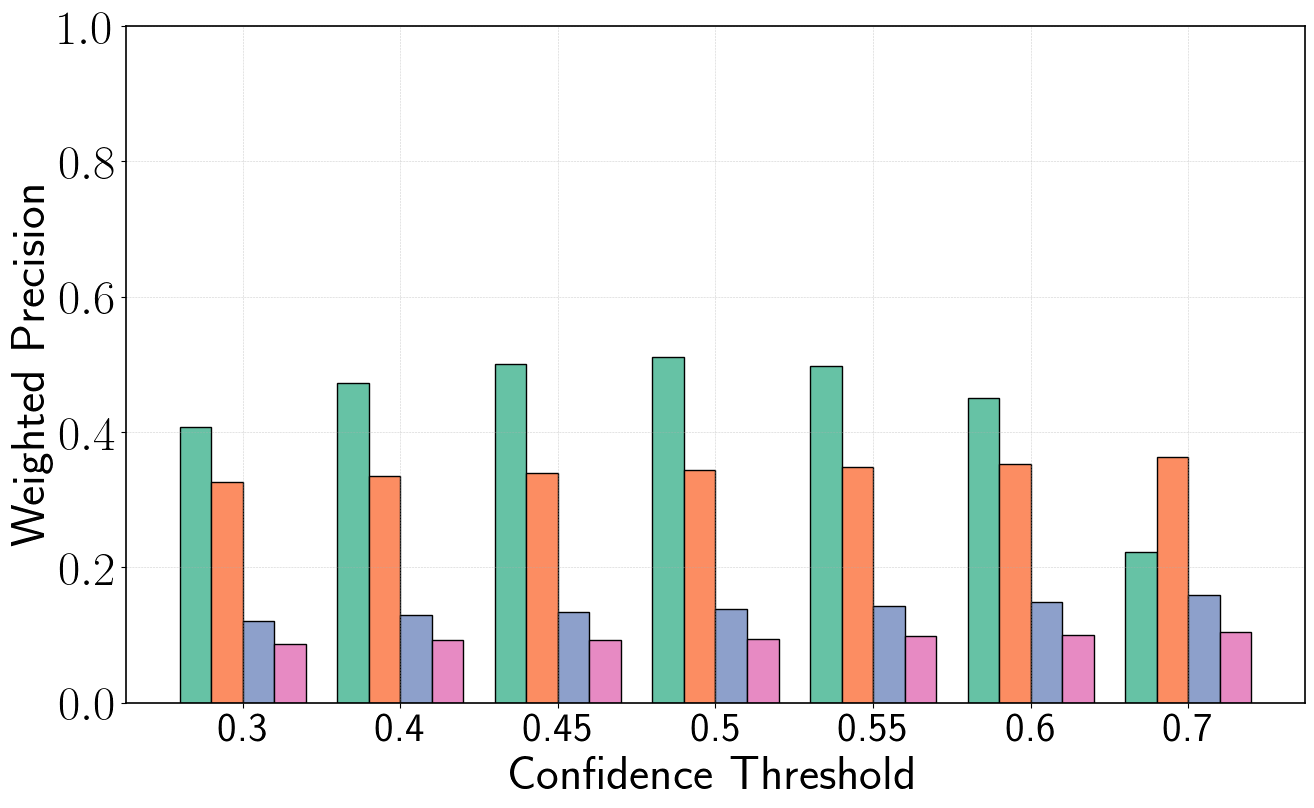

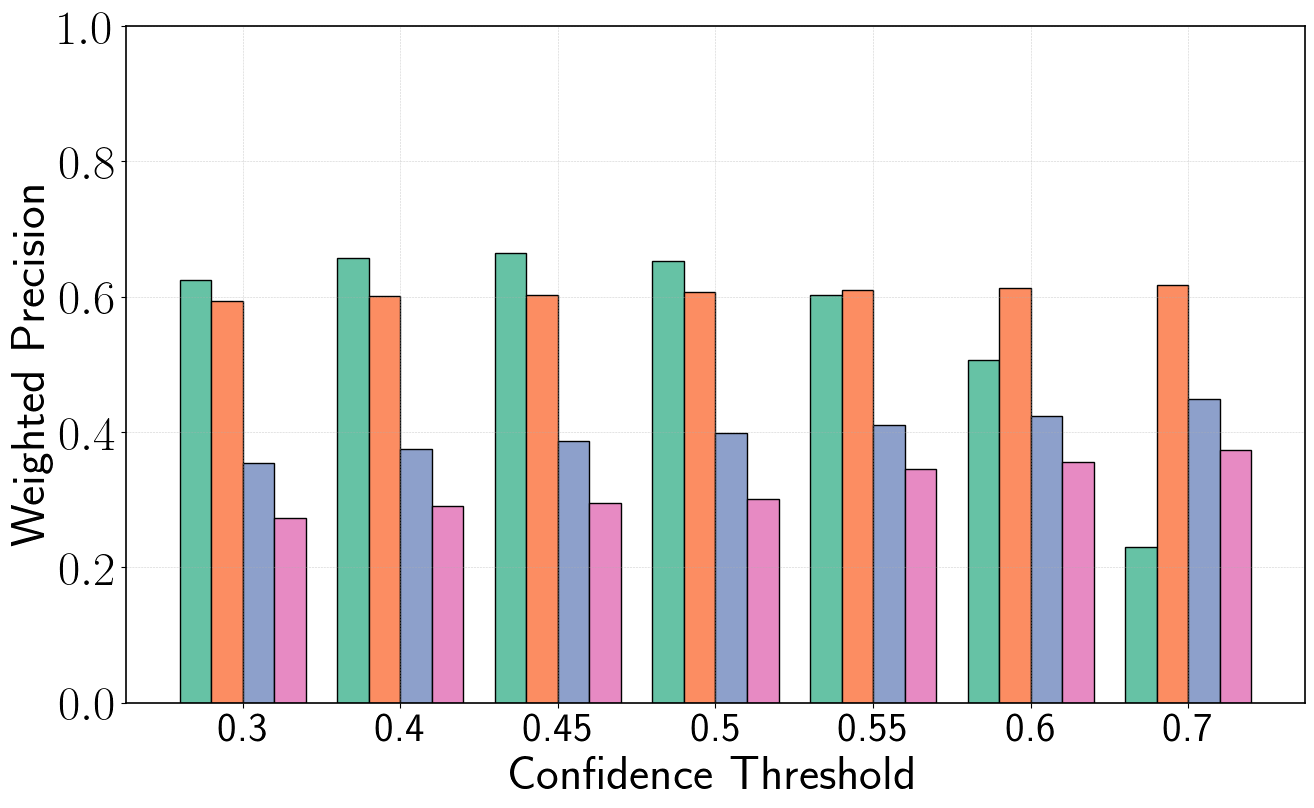

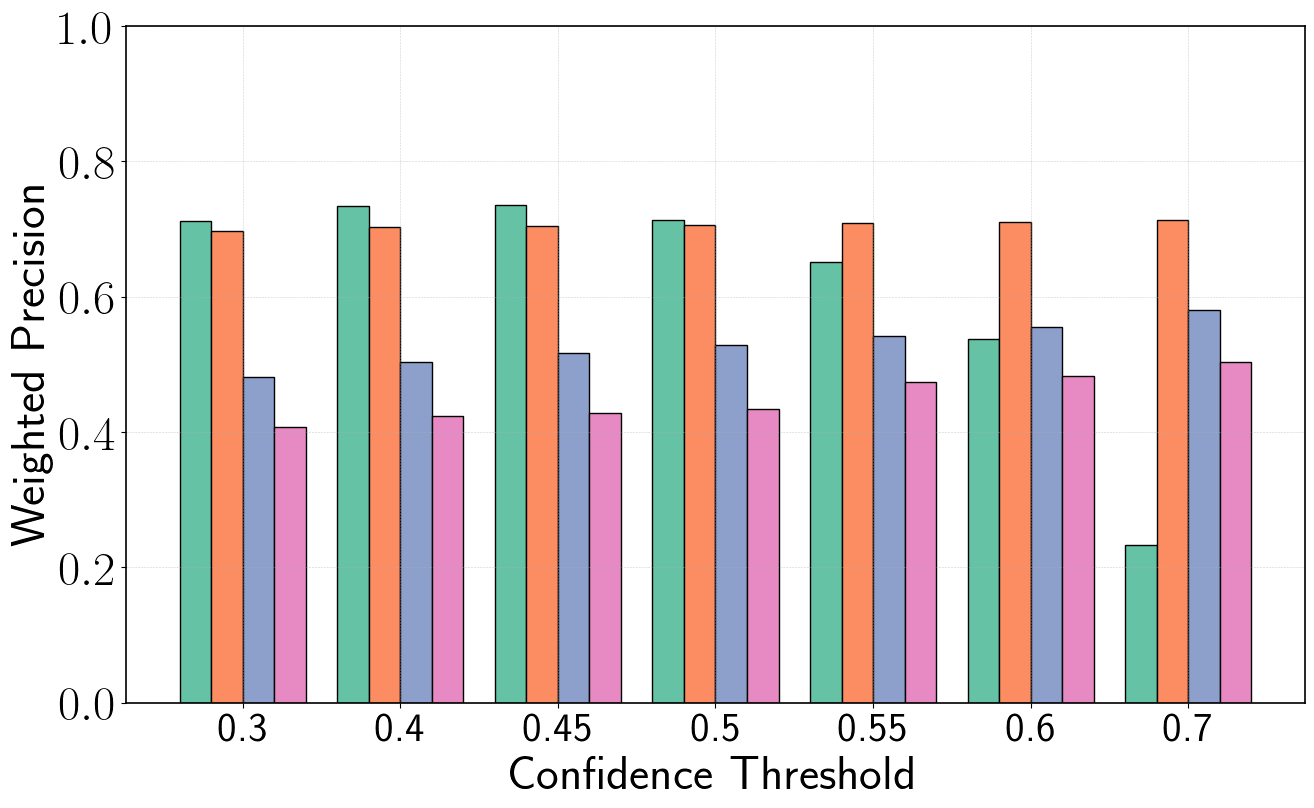

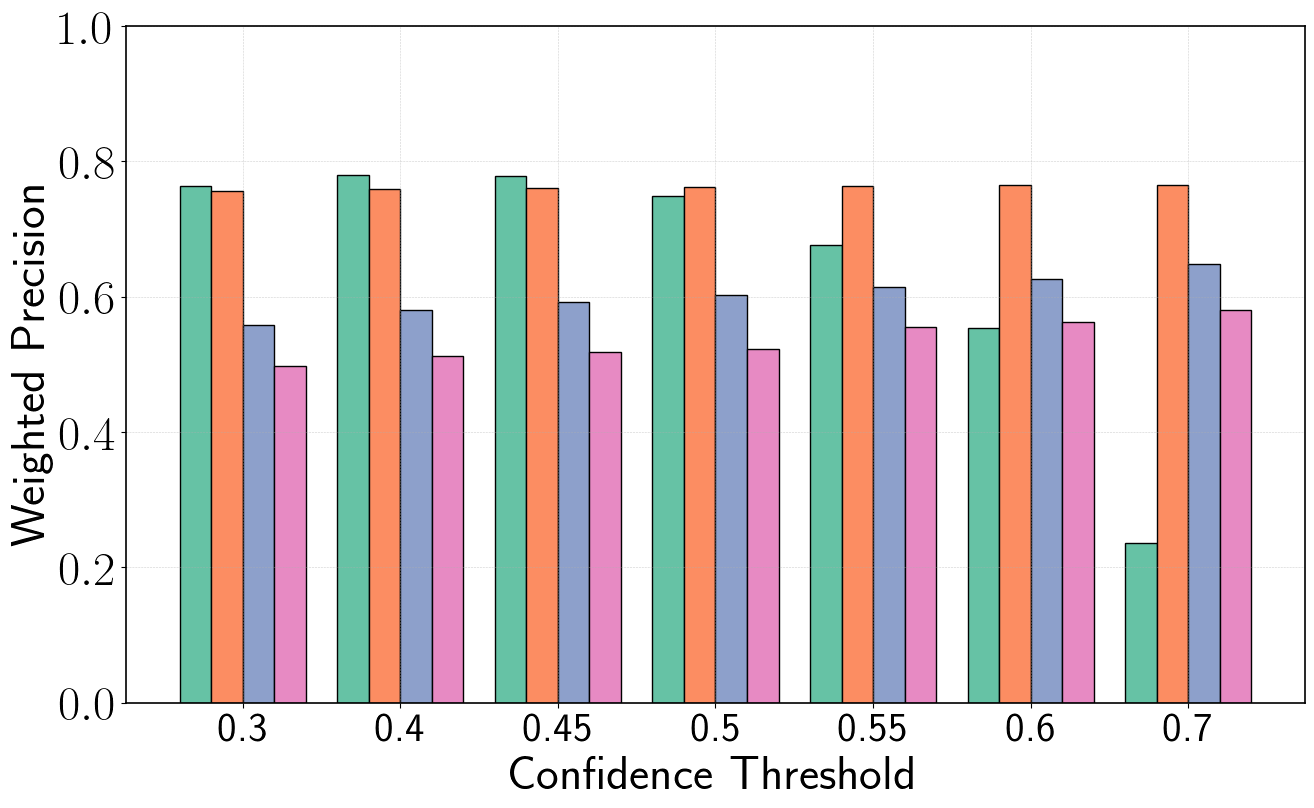

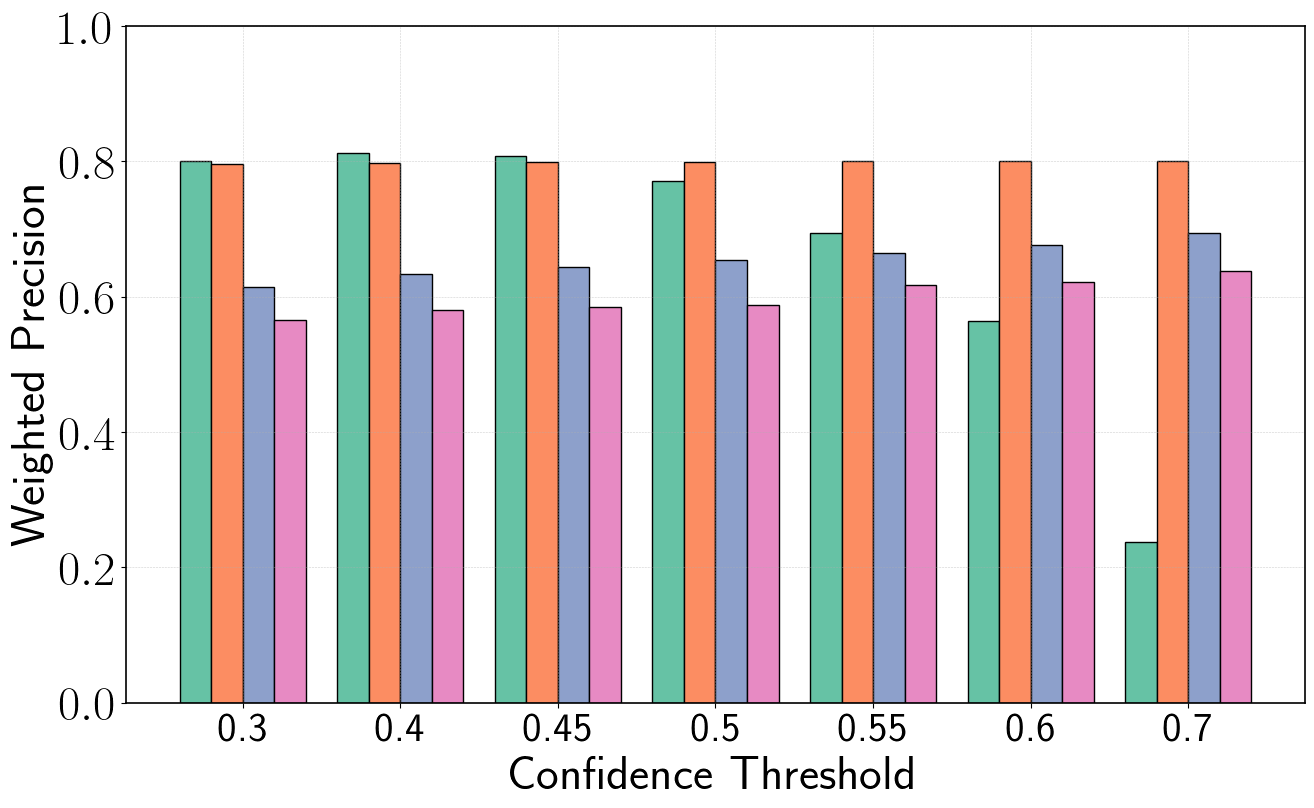

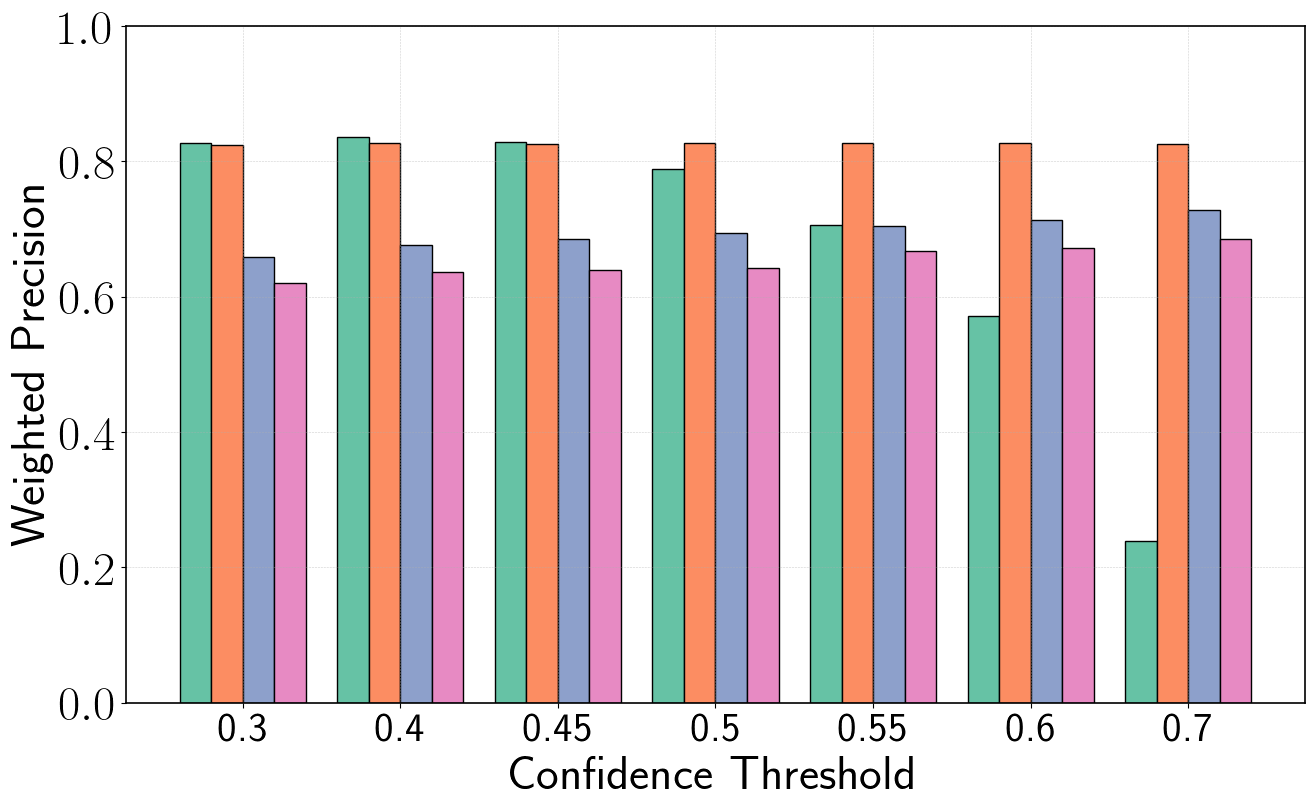

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pickle
plt.close('all')
# split_name = 'bindingdb_clean'
split_name = 'pdbbind'
results = pickle.load(open(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/weighted_precision_results_{split_name}.pkl', 'rb'))
mpl.rcParams.update({
    "figure.figsize": (14,8),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.linewidth": 1.2,
    "font.size": 35,
    "axes.labelsize": 35,
    "axes.titlesize": 35,
    "xtick.labelsize": 35,
    "ytick.labelsize": 35,
    "legend.fontsize": 35, 
    "font.weight": "normal"# chữ mỏng hơn (có thể dùng 'normal' hoặc 'book')
                                # Không dùng LaTeX nếu muốn font global có hiệu lực
})

# Palette Nature-like pastel
palette = sns.color_palette("Set2", n_colors=4)

methods = ["linker", "arkdta", "hots", "sprint"]
method_names = ["LINKER", "ArkDTA", "HoTS", "SPRINT"]
smooth_values = [1, 5, 10, 15, 20, 25]

for idx, smooth_value in enumerate(smooth_values):
    conf_thres_list = [t for t, _ in results["linker"][smooth_value]]
    x = np.arange(len(conf_thres_list))
    width = 0.2

    fig, ax = plt.subplots(figsize=(14,9))
    
    for i, method in enumerate(methods):
        scores = [score for _, score in results[method][smooth_value]]
        ax.bar(x + i*width, scores, width, label=method_names[i],
               color=palette[i], edgecolor='black')

    ax.set_xlabel("Confidence Threshold", fontname='DejaVu Sans')
    ax.set_ylabel("Weighted Precision", fontname='DejaVu Sans')
    # ax.set_title(f"Weighted Precision for Smoothing = {smooth_value}")
    ax.set_xticks(x + width*1.5)
    
    ax.set_ylim(0, 1)


    # Legend
    # ax.legend(loc="lower right")

    ax.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.6)

    # Save figure
    plt.tight_layout()
    # ax.set_xlim(0, 1.01)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # if idx <= 1:
    #     ax.legend(frameon=True, framealpha=0.8, loc='upper right')
    # else:
    #     ax.legend(frameon=True, framealpha=0.8, loc='lower center')
    
    plt.tight_layout()
    
    # --- Lưu PDF chuẩn Nature ---
    filename = f"/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/pdbsmooth/weighted_precision_smooth_{smooth_value}_{split_name}.pdf"
    plt.grid(True)
    ax.set_xticklabels(conf_thres_list)  
    plt.setp(ax.get_xticklabels(), fontname='DejaVu Sans', fontsize=30, fontweight='ultralight')
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    plt.show()


In [15]:
print(palette[0])
print(palette[1])
print(palette[2])
print(palette[3])

(0.4, 0.7607843137254902, 0.6470588235294118)
(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)


## 2. TSNE

In [ ]:
import torch
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from glob import glob
import pickle


string_name = 'val_tsne_bindingdb'
list_all_fg = []
list_all_vec = []
for path in glob(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/model/{string_name}/*'):
    with open(path, "rb") as f:
        loaded_dict = pickle.load(f)
    list_all_fg.append(loaded_dict['fg_type_tensor'])
    list_all_vec.append(loaded_dict['attn_out'])
    
    
labels = torch.concatenate(list_all_fg).cpu()
X = torch.concatenate(list_all_vec).cpu()
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)


data = {
    "X_2d": X_2d,       # numpy array shape [N, 2]
    "labels": labels    # list hoặc numpy array
}

with open(f"/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/{string_name}.pkl", "wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
glob('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/*tsne*')

['/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/tsne_pdbbind.pkl',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/val_tsne_pdbbind.pkl',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/train_tsne_bindingdb.pkl',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/train_tsne_pdbbind.pkl',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/tsne_nature.pdf',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/tsne_bindingdb.pkl',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/tsne_synthesis.pkl',
 '/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/val_tsne_bindingdb.pkl']

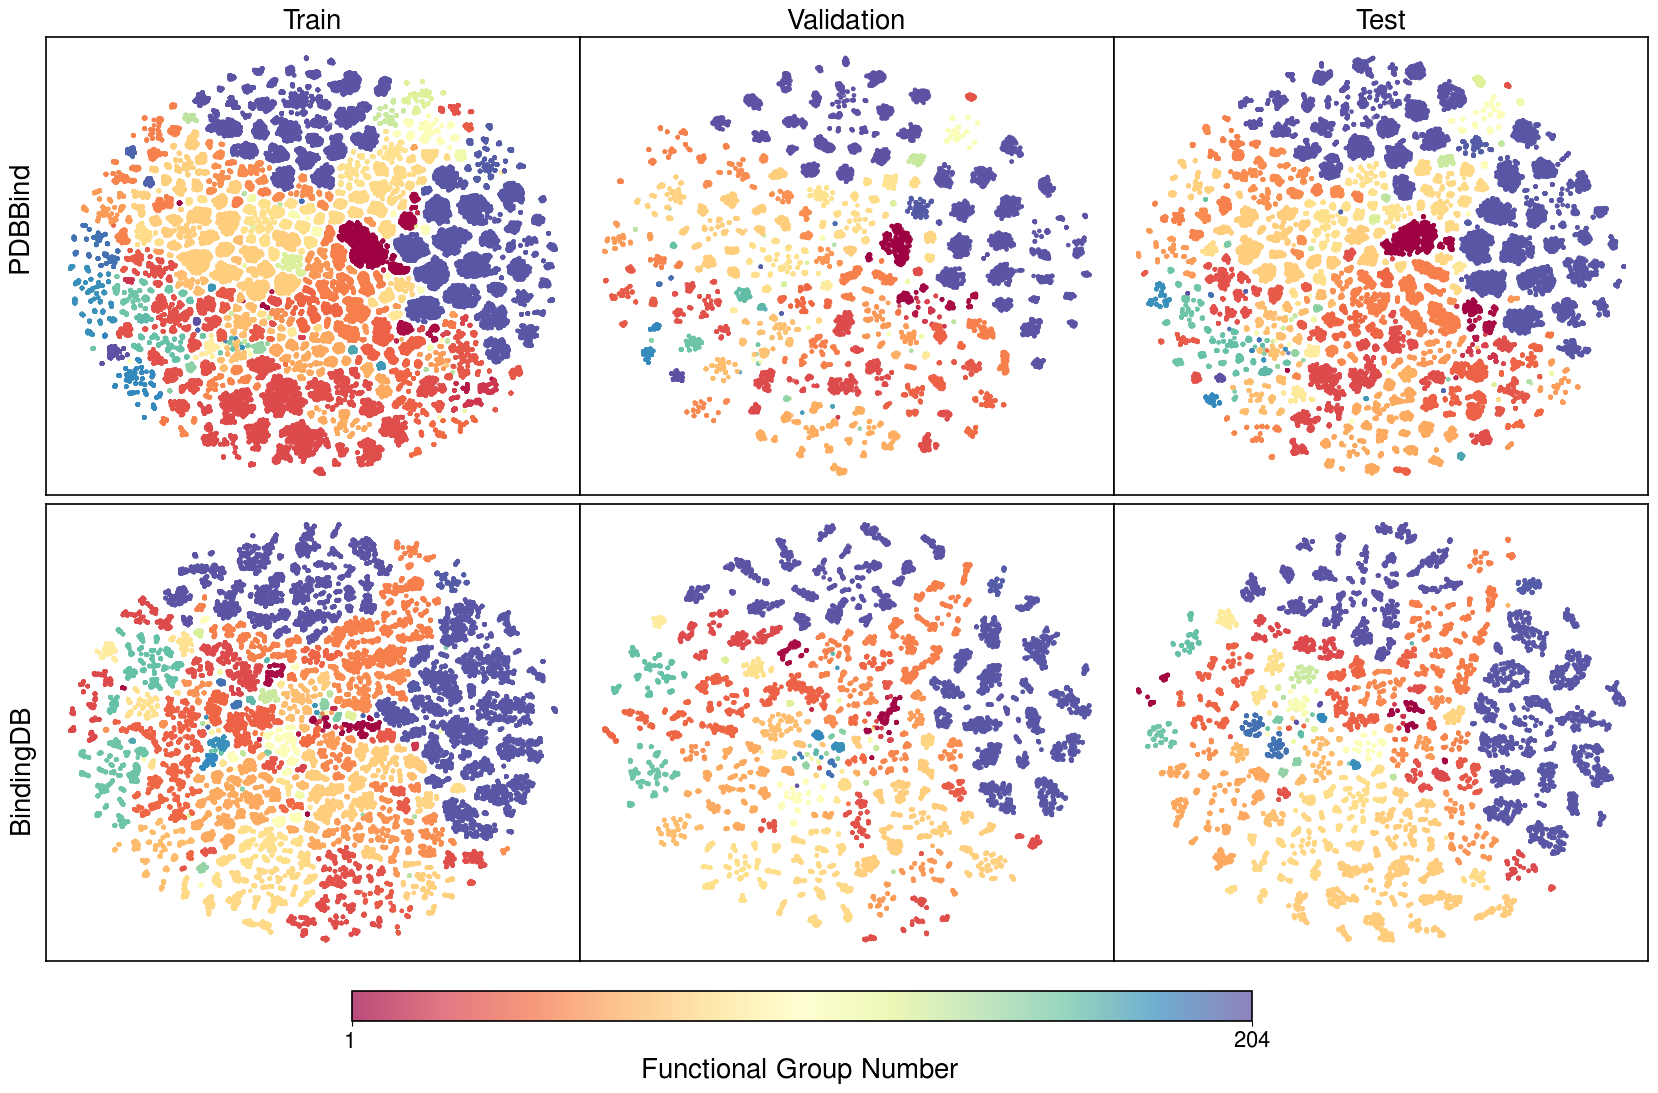

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ===============================
# Nature-style theme
# ===============================
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 26,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1.2,
    "axes.edgecolor": "black",
})

# ===============================
# Load TSNE data
# ===============================
base_path = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src"

def load_tsne(name):
    with open(f"{base_path}/{name}.pkl", "rb") as f:
        data = pickle.load(f)
    return data["X_2d"], data["labels"]

# ---- Train
X1_train, labels1_train = load_tsne("train_tsne_pdbbind")
X2_train, labels2_train = load_tsne("train_tsne_bindingdb")
# X2_train = np.column_stack((-X2_train[:, 0], X2_train[:, 1]))

# ---- Val
X1_val, labels1_val = load_tsne("val_tsne_pdbbind")
X2_val, labels2_val = load_tsne("val_tsne_bindingdb")
# X2_val = np.column_stack((-X2_val[:, 0], X2_val[:, 1]))

# ---- Test
X1_test, labels1_test = load_tsne("tsne_pdbbind")
X2_test, labels2_test = load_tsne("tsne_bindingdb")
X2_test = np.column_stack((-X2_test[:, 0], X2_test[:, 1]))

# ===============================
# Figure layout: 2 rows × 3 cols
# ===============================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

datasets = [
    (X1_train, labels1_train),
    (X1_val,   labels1_val),
    (X1_test,  labels1_test),
    (X2_train, labels2_train),
    (X2_val,   labels2_val),
    (X2_test,  labels2_test),
]

# ===============================
# Scatter plots
# ===============================
sc_for_cbar = None
cmap = plt.cm.Spectral

for ax, (X, labels) in zip(axes.flatten(), datasets):
    sc = ax.scatter(
        X[:, 0], X[:, 1],
        c=labels,
        cmap=cmap,
        s=5,
        alpha=0.7, rasterized=True)
    if sc_for_cbar is None:
        sc_for_cbar = sc

    ax.set_xticks([])
    ax.set_yticks([])

# ===============================
# Column titles
# ===============================
col_titles = ["Train", "Validation", "Test"]
for i, title in enumerate(col_titles):
    axes[0, i].set_title(title, fontsize = 20)

# ===============================
# Row labels (Nature-style)
# ===============================
fig.text(0.06, 0.73, "PDBBind",
         fontsize=20, fontweight="bold",
         rotation=90, va="center")

fig.text(0.06, 0.27, "BindingDB",
         fontsize = 20, fontweight="bold",
         rotation=90, va="center")

# ===============================
# Horizontal colorbar (stick style)
# ===============================
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.025])
cbar = fig.colorbar(sc_for_cbar, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks([1, 204])
cbar.set_ticklabels(["1", "204"])
cbar.set_label("Functional Group Number", fontsize=20)

# ===============================
# Layout & save
# ===============================
plt.subplots_adjust(left=0.08, right=0.97, wspace=0.00, hspace=0.02)

plt.savefig(
    "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/tsne_2x3.pdf",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [ ]:
labels1_train

tensor([ 61,  61,  69,  ..., 202, 202, 202])

In [ ]:
import torch
all_labels = torch.concatenate((labels1_train, labels2_train, labels1_val, labels2_val, labels1_test, labels2_test))

In [ ]:
import seaborn as sns
from scipy.stats import gaussian_kde
# Gom nhãn từ cả 2 dataset để tính tần suất tổng quát
all_labels_np = all_labels.numpy()
unique, counts = np.unique(all_labels_np, return_counts=True)
label_freq = dict(zip(unique, counts))

# (a) Chọn 3 nhóm phổ biến nhất và 3 nhóm hiếm nhất (loại bỏ nhãn 0 nếu có)
sorted_indices = np.argsort(counts)[::-1]
common_fgs = unique[sorted_indices[:5]]  # Ví dụ: Amine, Alcohol, Carbonyl
rare_fgs = unique[sorted_indices[-5:]]   # Các nhóm có rất ít mẫu

In [ ]:
import pandas as pd
df = pd.read_csv('pyCheckmol/data/fg_list.csv', sep = ';')
mapping_dict = dict(zip(df['FG_number'], df['FG_name']))

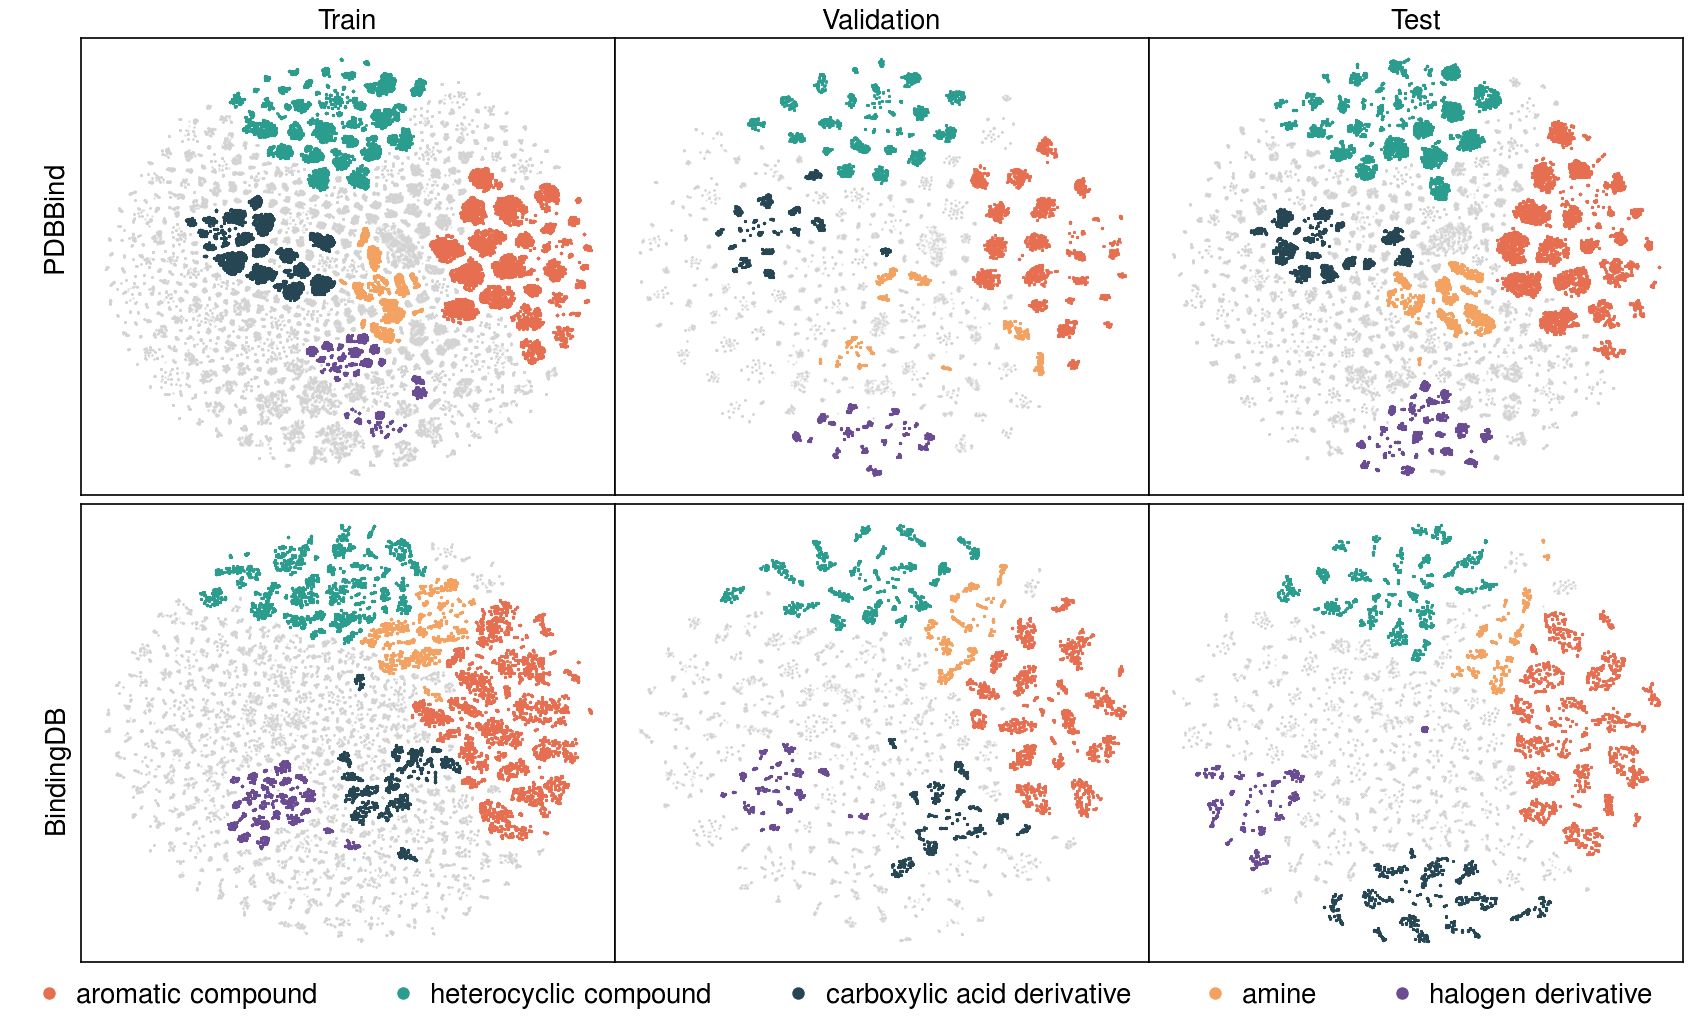

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# ===============================
# Nature-style theme
# ===============================
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 28,
    "axes.labelsize": 20,
    "axes.titlesize": 24,
    "axes.linewidth": 1.2,
    "axes.edgecolor": "black",
})

# ===============================
# Load TSNE data
# ===============================
base_path = ""

def load_tsne(name):
    with open(f"{base_path}/{name}.pkl", "rb") as f:
        data = pickle.load(f)
    return data["X_2d"], data["labels"]

# ---- Train
X1_train, labels1_train = load_tsne("train_tsne_pdbbind")
X2_train, labels2_train = load_tsne("train_tsne_bindingdb")

# ---- Val
X1_val, labels1_val = load_tsne("val_tsne_pdbbind")
X2_val, labels2_val = load_tsne("val_tsne_bindingdb")

# ---- Test
X1_test, labels1_test = load_tsne("tsne_pdbbind")
X2_test, labels2_test = load_tsne("tsne_bindingdb")
X2_test = np.column_stack((-X2_test[:, 0], X2_test[:, 1]))

# ===============================
# Datasets (2 × 3)
# ===============================
datasets = [
    (X1_train, labels1_train),
    (X1_val,   labels1_val),
    (X1_test,  labels1_test),
    (X2_train, labels2_train),
    (X2_val,   labels2_val),
    (X2_test,  labels2_test),
]

# ===============================
# COMMON MOTIFS
# ===============================
common_fgs = np.array(common_fgs)

beautiful_colors = [
    "#E76F51",
    "#2A9D8F",
    "#264653",
    "#F4A261",
    "#6A4C93",
]

fg_color_map = dict(zip(common_fgs, beautiful_colors))

# ===============================
# Figure: 2 × 3
# ===============================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ===============================
# Plot
# ===============================
for ax, (X, labels) in zip(axes.flatten(), datasets):

    # --- Background (gray)
    ax.scatter(
        X[:, 0], X[:, 1],
        c="lightgray",
        s=2,
        alpha=0.4,
        linewidths=0, rasterized = True
    )

    # --- Overlay common motifs
    for fg in common_fgs:
        mask = labels == fg
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            color=fg_color_map[fg],
            s=5,
            alpha=0.9,
            linewidths=0, rasterized = True
        )

    ax.set_xticks([])
    ax.set_yticks([])

# ===============================
# Column titles
# ===============================
col_titles = ["Train", "Validation", "Test"]
for i, title in enumerate(col_titles):
    axes[0, i].set_title(title, fontsize = 20)

# ===============================
# Row labels (Nature-style)
# ===============================
fig.text(0.06, 0.73, "PDBBind",
         fontsize=20, fontweight="bold",
         rotation=90, va="center")

fig.text(0.06, 0.27, "BindingDB",
         fontsize = 20, fontweight="bold",
         rotation=90, va="center")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"{mapping_dict[fg].replace('deriv.', 'derivative')}",
        markerfacecolor=fg_color_map[fg],
        markersize=10
    )
    for fg in common_fgs
]

fig.legend(
    handles=legend_elements,
    loc="lower center",
    ncol=len(common_fgs),      # 1 hàng
    frameon=False,
    fontsize=20,
    bbox_to_anchor=(0.5, 0.05), handletextpad=0.01,    # khoảng cách giữa marker và chữ
    labelspacing=0.01     # khoảng cách giữa các hàng (nếu nhiều hàng)
)

# ===============================
# Layout & save
# ===============================
plt.subplots_adjust(left=0.08, right=0.97, wspace=0.00, hspace=0.02)

plt.savefig(
    "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/tsne_common_motifs.pdf",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ===============================
# Nature-style theme
# ===============================
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 26,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1.2,
    "axes.edgecolor": "black",
})

# ===============================
# Load TSNE data
# ===============================
base_path = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src"

def load_tsne(name):
    with open(f"{base_path}/{name}.pkl", "rb") as f:
        data = pickle.load(f)
    return data["X_2d"], data["labels"]

# ---- Train
X1_train, labels1_train = load_tsne("train_tsne_pdbbind")
X2_train, labels2_train = load_tsne("train_tsne_bindingdb")
# X2_train = np.column_stack((-X2_train[:, 0], X2_train[:, 1]))

# ---- Val
X1_val, labels1_val = load_tsne("val_tsne_pdbbind")
X2_val, labels2_val = load_tsne("val_tsne_bindingdb")
# X2_val = np.column_stack((-X2_val[:, 0], X2_val[:, 1]))

# ---- Test
X1_test, labels1_test = load_tsne("tsne_pdbbind")
X2_test, labels2_test = load_tsne("tsne_bindingdb")
X2_test = np.column_stack((-X2_test[:, 0], X2_test[:, 1]))

# ===============================
# Figure layout: 2 rows × 3 cols
# ===============================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

datasets = [
    (X1_train, labels1_train),
    (X1_val,   labels1_val),
    (X1_test,  labels1_test),
    (X2_train, labels2_train),
    (X2_val,   labels2_val),
    (X2_test,  labels2_test),
]

# ===============================
# Scatter plots
# ===============================
sc_for_cbar = None
cmap = plt.cm.Spectral

for ax, (X, labels) in zip(axes.flatten(), datasets):
    sc = ax.scatter(
        X[:, 0], X[:, 1],
        c=labels,
        cmap=cmap,
        s=5,
        alpha=0.7, rasterized=True)
    if sc_for_cbar is None:
        sc_for_cbar = sc

    ax.set_xticks([])
    ax.set_yticks([])

# ===============================
# Column titles
# ===============================
col_titles = ["Train", "Validation", "Test"]
for i, title in enumerate(col_titles):
    axes[0, i].set_title(title, fontsize = 20)

# ===============================
# Row labels (Nature-style)
# ===============================
fig.text(0.06, 0.73, "PDBBind",
         fontsize=20, fontweight="bold",
         rotation=90, va="center")

fig.text(0.06, 0.27, "BindingDB",
         fontsize = 20, fontweight="bold",
         rotation=90, va="center")

# ===============================
# Horizontal colorbar (stick style)
# ===============================
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.025])
cbar = fig.colorbar(sc_for_cbar, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks([1, 204])
cbar.set_ticklabels(["1", "204"])
cbar.set_label("Functional Group Number", fontsize=20)

# ===============================
# Layout & save
# ===============================
plt.subplots_adjust(left=0.08, right=0.97, wspace=0.00, hspace=0.02)

plt.savefig(
    "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/tsne_2x3.pdf",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [ ]:

split = 'test'
string_name1 = 'tsne_pdbbind'
string_name2 = 'tsne_bindingdb'
# =========================
# Load PDBBind
# =========================
with open(f"/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/{string_name1}.pkl", "rb") as f:
    data1 = pickle.load(f)

with open(f"/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/{string_name2}.pkl", "rb") as f:
    data2 = pickle.load(f)
    
import torch
all_labels1 = torch.concatenate((labels1_train, labels1_val,labels1_test))
all_labels2  = torch.concatenate((labels2_train, labels2_val, labels2_test))
a = set(int(x) for x in all_labels1.unique())
b = set(int(x) for x in all_labels2.unique())

intersection = a & b

print(intersection)

lst_id = []
lst_dict = dict()
for i in intersection:
    if 'amine' in mapping_dict[i] or 'amide' in mapping_dict[i] or 'alcohol' in mapping_dict[i] or 'ether' in mapping_dict[i]:
        lst_id.append(i)
        lst_dict[i] = mapping_dict[i].strip()

{1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 63, 64, 68, 69, 70, 71, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 97, 99, 101, 103, 106, 107, 108, 109, 113, 114, 115, 116, 117, 125, 126, 127, 133, 135, 136, 137, 138, 140, 141, 146, 147, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 173, 178, 179, 180, 181, 183, 185, 191, 192, 193, 195, 199, 200, 201, 202, 203, 204}


In [ ]:
# ===============================
# FUNCTIONAL GROUP FAMILIES
# ===============================

alcohol_groups = [x for x, k in lst_dict.items() if 'alcohol' in k]


ether_groups = [x for x, k in lst_dict.items() if 'ether' in k]


amine_groups = [x for x, k in lst_dict.items() if 'amine' in k]


amide_groups = [x for x, k in lst_dict.items() if 'amide' in k]


group_names = lst_dict

base_path = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src"

def load_tsne(name):
    with open(f"{base_path}/{name}.pkl", "rb") as f:
        data = pickle.load(f)
    return data["X_2d"], data["labels"]

# ---- Train
X1_train, labels1_train = load_tsne("train_tsne_pdbbind")
X2_train, labels2_train = load_tsne("train_tsne_bindingdb")
# X2_train = np.column_stack((-X2_train[:, 0], X2_train[:, 1]))

# ---- Val
X1_val, labels1_val = load_tsne("val_tsne_pdbbind")
X2_val, labels2_val = load_tsne("val_tsne_bindingdb")
# X2_val = np.column_stack((-X2_val[:, 0], X2_val[:, 1]))

# ---- Test
X1_test, labels1_test = load_tsne("tsne_pdbbind")
X2_test, labels2_test = load_tsne("tsne_bindingdb")
X2_test = np.column_stack((-X2_test[:, 0], X2_test[:, 1]))

datasets = [
    (0, 0, X1_train, labels1_train, "Train"),
    (0, 1, X1_val,   labels1_val,   "Validation"),
    (0, 2, X1_test,  labels1_test,  "Test"),
    (1, 0, X2_train, labels2_train, "Train"),
    (1, 1, X2_val,   labels2_val,   "Validation"),
    (1, 2, X2_test,  labels2_test,  "Test"),
]

row_names = ["PDBBind", "BindingDB"]

families = {
    "Alcohol family": (alcohol_groups, "teal", "lightgrey"),
    "Ether family":   (ether_groups,   "purple", "thistle"),
    "Amine family":   (amine_groups,   "royalblue", "lightsteelblue"),
    "Amide family":   (amide_groups,   "darkorange", "peachpuff"),
}


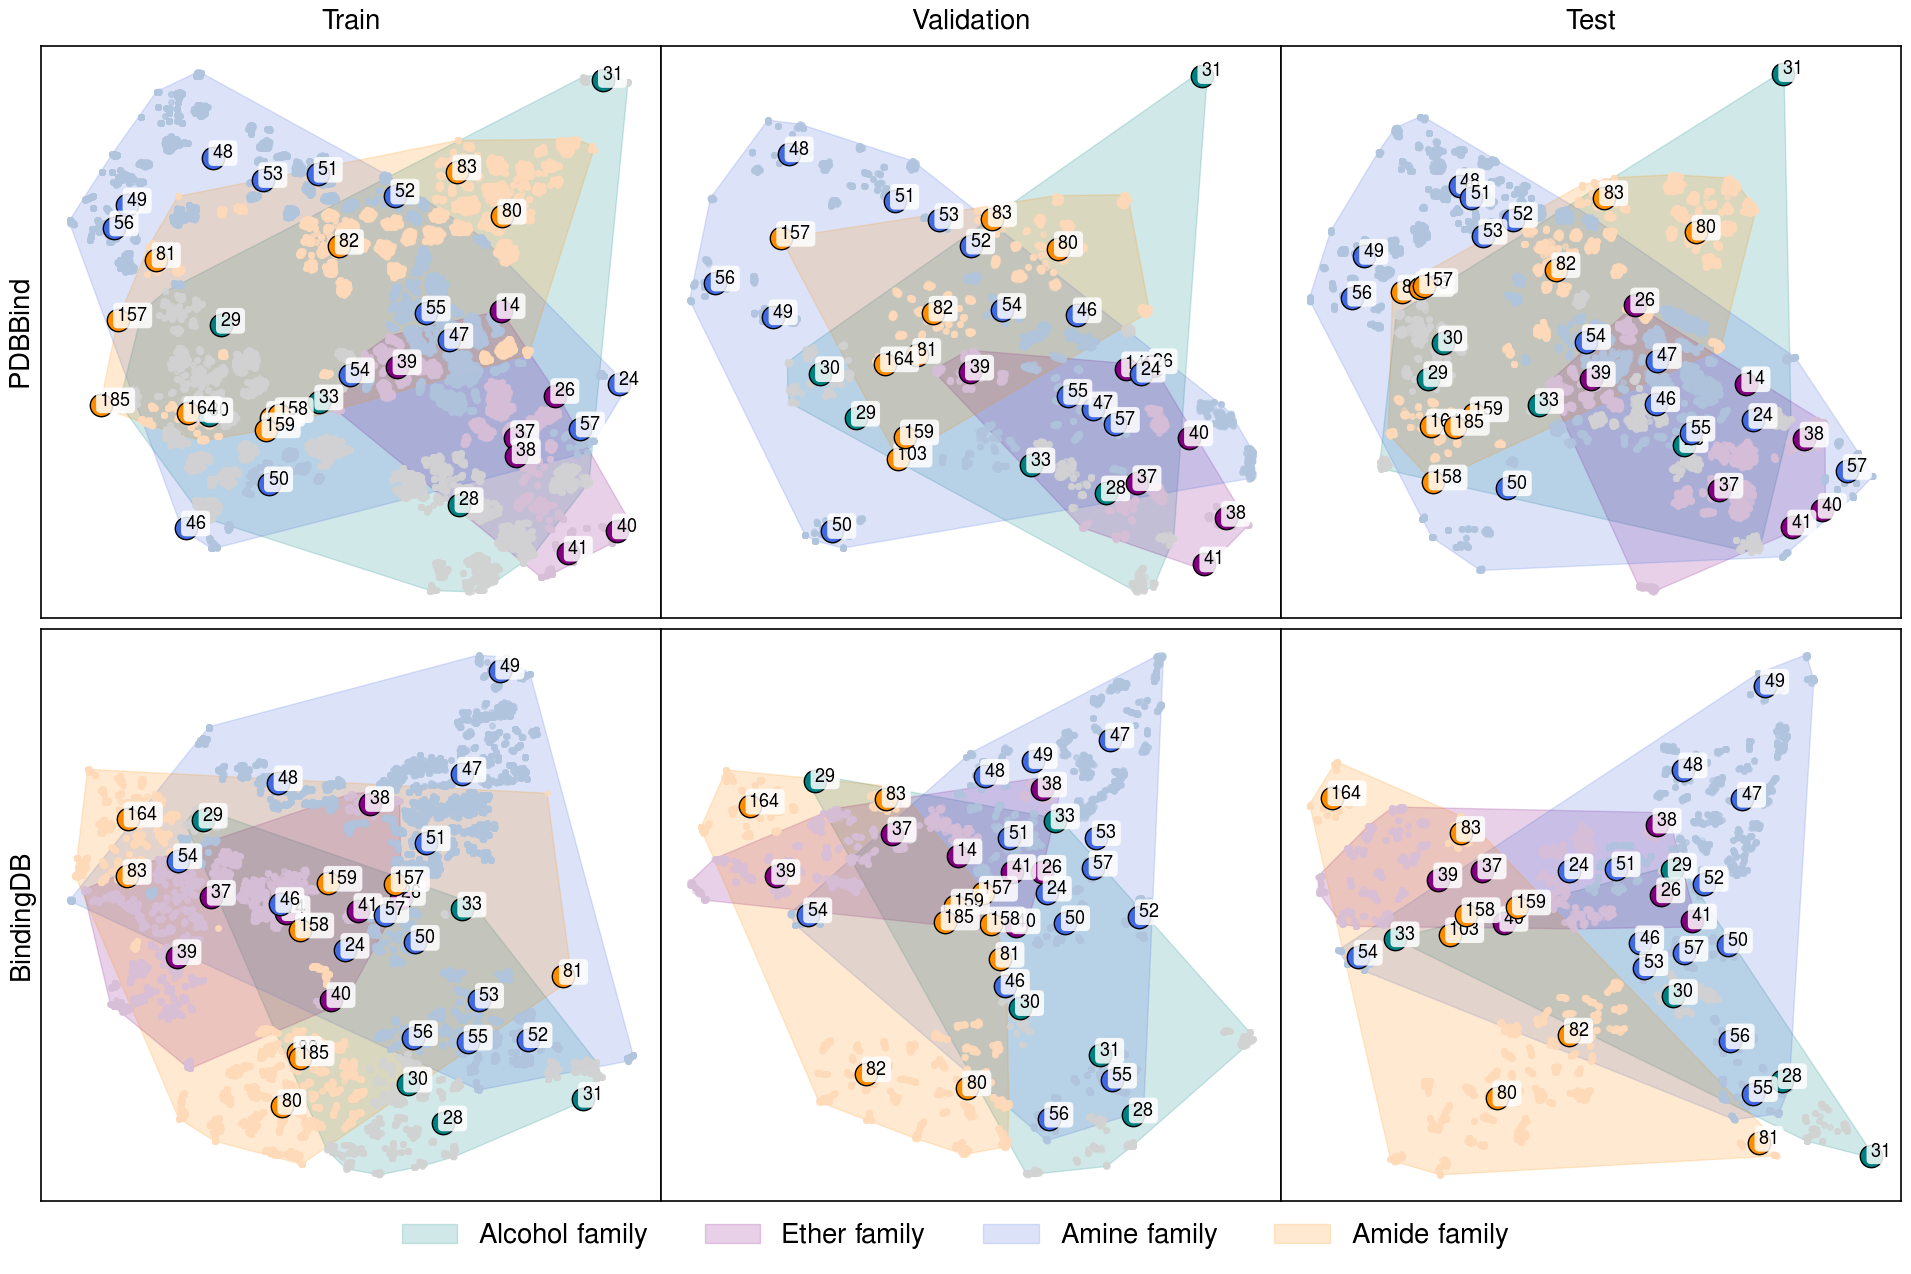

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from adjustText import adjust_text
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# --- Nature-style theme ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "axes.linewidth": 1.2,
    "axes.edgecolor": "black",
    "patch.edgecolor": "black",
    "grid.linewidth": 0.4,
})

fig, axes = plt.subplots(2, 3, figsize=(24, 14))


legend_handles = {}

for r, c, X, labels, split_name in datasets:
    ax = axes[r, c]
    texts = []

    for fam_name, (groups, hull_color, pt_color) in families.items():
        mask = np.isin(labels, groups)
        pts = X[mask][:, :2]

        # Convex hull
        if len(pts) >= 3:
            hull = ConvexHull(pts)
            hpts = pts[hull.vertices]
            poly = ax.fill(
                hpts[:, 0], hpts[:, 1],
                color=hull_color,
                alpha=0.18,
                zorder=0
            )
            legend_handles[fam_name] = poly[0]

        # Points
        ax.scatter(
            pts[:, 0], pts[:, 1],
            c=pt_color,
            s=15,
            alpha=0.4,
            zorder=1,
            rasterized=True
        )

        # Centroids
        for fg in groups:
            idx = np.where(labels == fg)[0]
            if len(idx) > 0:
                centroid = np.mean(X[idx][:, :2], axis=0)
                ax.scatter(
                    centroid[0], centroid[1],
                    s=260,
                    color=hull_color,
                    edgecolors="black",
                    zorder=3
                )
                ax.text(
                    centroid[0], centroid[1],
                    str(fg),
                    fontsize=13,
                    fontweight="bold",
                    bbox=dict(
                        boxstyle="round,pad=0.25",
                        fc="white",
                        ec="none",
                        alpha=0.85
                    )
                )

    # Column titles (Train / Val / Test)
    if r == 0:
        ax.set_title(split_name, fontsize=20, pad=12)

    ax.set_xticks([])
    ax.set_yticks([])

for r, row_name in enumerate(row_names):
    axes[r, 0].annotate(
        row_name,
        xy=(-0.03, 0.5),
        xycoords="axes fraction",
        fontsize=20,
        fontweight="bold",
        rotation=90,
        va="center",
        ha="center"
    )

fig.legend(
    legend_handles.values(),
    legend_handles.keys(),
    loc="lower center",
    ncol=4,
    frameon=False,
    fontsize=20
)

plt.subplots_adjust(
    wspace=0.0,
    hspace=0.02,
    bottom=0.055
)

plt.savefig(
    "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/fg_clusters.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True
)
plt.show()


In [ ]:
for i in common_fgs:
    print(i,mapping_dict[i])

201 aromatic compound 
202 heterocyclic compound 
75 carboxylic acid deriv. 
47 amine 
61 halogen deriv. 


## 3. ROC-Curve, PR-Curve

### 3.1. Pocket prediction

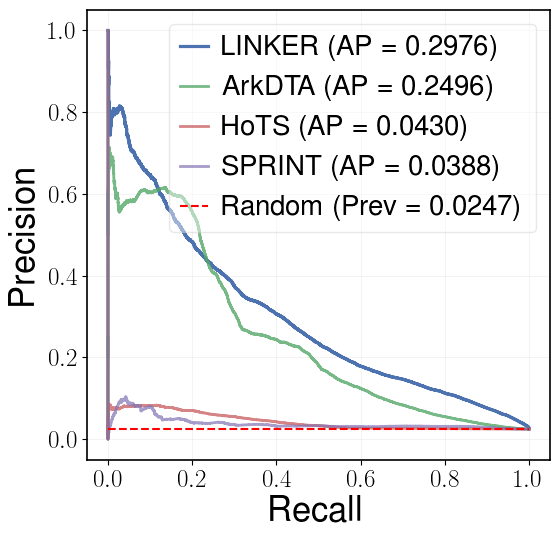

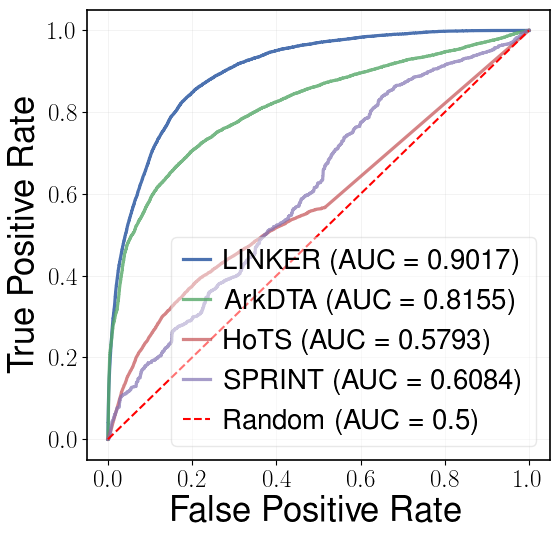

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

with open("/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/curve_data_y_bindingdb_clean.pkl", "rb") as f:
    results = pickle.load(f)


y_true_all = results["y_true_all"]
# Lấy dữ liệu ra
rec_my = results["rec_my"]
prec_my = results["prec_my"]
ap_my = results["ap_my"]

rec_ark = results["rec_ark"]
prec_ark = results["prec_ark"]
ap_ark = results["ap_ark"]

rec_sprint = results["rec_sprint"]
prec_sprint = results["prec_sprint"]
ap_sprint = results["ap_sprint"]

rec_hots = results["rec_hots"]
prec_hots = results["prec_hots"]
ap_hots = results["ap_hots"]

fpr_my = results["fpr_my"]
tpr_my = results["tpr_my"]
roc_auc_my = results["roc_auc_my"]

fpr_ark = results["fpr_ark"]
tpr_ark = results["tpr_ark"]
roc_auc_ark = results["roc_auc_ark"]

fpr_sprint = results["fpr_sprint"]
tpr_sprint = results["tpr_sprint"]
roc_auc_sprint = results["roc_auc_sprint"]

fpr_hots = results["fpr_hots"]
tpr_hots = results["tpr_hots"]
roc_auc_hots = results["roc_auc_hots"]
prevalence = y_true_all.mean()

# --- Nature-style theme ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20,
    "axes.labelsize": 25,
    "axes.titlesize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,
    "axes.linewidth": 1.2,
    "axes.edgecolor": "black",
    "patch.edgecolor": "black",
    "grid.linewidth": 0.4,
})
prevalence = y_true_all.mean()
# Soft pastel palette (Nature-like)
colors = [
    "#4C72B0",  # soft blue
    "#55A868",  # soft green
    "#C44E52",  # soft red
    "#8172B3"   # soft purple
]
# Blue, Green, Red, Purple
plt.figure(figsize=(6,5.8))


plt.plot(rec_my, prec_my, label=rf"LINKER (AP = {ap_my:.4f})",
         color=colors[0], lw=2.3)

plt.plot(rec_ark, prec_ark, 
         label=rf"ArkDTA (AP = {ap_ark:.4f})",
         color=colors[1], lw=2.0, alpha=0.8)

plt.plot(rec_hots, prec_hots, 
         label=rf"HoTS (AP = {ap_hots:.4f})",
         color=colors[2], lw=2.0, alpha=0.7)

plt.plot(rec_sprint, prec_sprint, 
         label=rf"SPRINT (AP = {ap_sprint:.4f})",
         color=colors[3], lw=2.0, alpha=0.7)

# Random baseline (Nature sử dụng nét mảnh)
plt.hlines(prevalence, xmin=0, xmax=1, colors='red',
           linestyles='--', lw=1.5,
           label=rf'Random (Prev = {prevalence:.4f})')

plt.xlabel("Recall")
plt.ylabel("Precision")

# Nature-style: remove top/right border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)

plt.grid(True, alpha=0.25)
plt.legend(
    frameon=True, framealpha=0.45,   # độ nhạt (0 = trong suốt, 1 = đậm)
    # bbox_to_anchor=(1 - 0.9, 1 - 0.35),
    loc="upper right",
    handlelength=1,      # 🔥 không vẽ đường
    handletextpad=0.5,   # sát chữ
)
plt.tight_layout()
plt.show()
# plt.savefig("pr_curve_bindingdb_clean_font.pdf", format="pdf", dpi=600)
# plt.close()
plt.figure(figsize=(6,5.8))

plt.plot(fpr_my, tpr_my, 
         label=rf"LINKER (AUC = {roc_auc_my:.4f})",
         color=colors[0], lw=2.3)

plt.plot(fpr_ark, tpr_ark,
         label=rf"ArkDTA (AUC = {roc_auc_ark:.4f})",
         color=colors[1], lw=2.3, alpha=0.8)

plt.plot(fpr_hots, tpr_hots,
         label=rf"HoTS (AUC = {roc_auc_hots:.4f})",
         color=colors[2], lw=2.3, alpha=0.7)

plt.plot(fpr_sprint, tpr_sprint,
         label=rf"SPRINT (AUC = {roc_auc_sprint:.4f})",
         color=colors[3], lw=2.3, alpha=0.7)



# Random diagonal
plt.plot([0,1], [0,1], color="red", lw=1.5, linestyle="--",
         label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Nature border style
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)

plt.grid(True, alpha=0.25)
plt.legend(frameon=True, framealpha=0.45,
    handlelength=1,      # 🔥 không vẽ đường
    handletextpad=0.5,   # sát chữ
)
plt.tight_layout()
# plt.savefig("roc_curve_bindingdb_clean_font.pdf", format="pdf", dpi=600)
# plt.close()
plt.show()

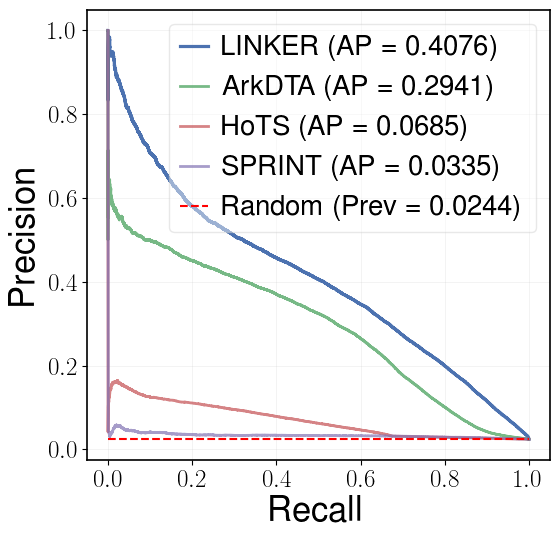

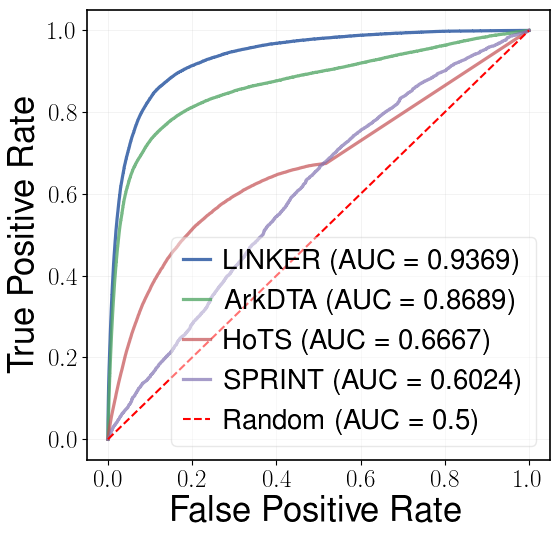

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

with open("/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/curve_data_y_pdbbind.pkl", "rb") as f:
    results = pickle.load(f)


y_true_all = results["y_true_all"]
# Lấy dữ liệu ra
rec_my = results["rec_my"]
prec_my = results["prec_my"]
ap_my = results["ap_my"]

rec_ark = results["rec_ark"]
prec_ark = results["prec_ark"]
ap_ark = results["ap_ark"]

rec_sprint = results["rec_sprint"]
prec_sprint = results["prec_sprint"]
ap_sprint = results["ap_sprint"]

rec_hots = results["rec_hots"]
prec_hots = results["prec_hots"]
ap_hots = results["ap_hots"]

fpr_my = results["fpr_my"]
tpr_my = results["tpr_my"]
roc_auc_my = results["roc_auc_my"]

fpr_ark = results["fpr_ark"]
tpr_ark = results["tpr_ark"]
roc_auc_ark = results["roc_auc_ark"]

fpr_sprint = results["fpr_sprint"]
tpr_sprint = results["tpr_sprint"]
roc_auc_sprint = results["roc_auc_sprint"]

fpr_hots = results["fpr_hots"]
tpr_hots = results["tpr_hots"]
roc_auc_hots = results["roc_auc_hots"]

prevalence = y_true_all.mean()
# --- Nature-style theme ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20,
    "axes.labelsize": 25,
    "axes.titlesize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,
    "axes.linewidth": 1.2,
    "axes.edgecolor": "black",
    "patch.edgecolor": "black",
    "grid.linewidth": 0.4,
})

# Soft pastel palette (Nature-like)

# Palette Nature-like pastel
colors = [
    "#4C72B0",  # soft blue
    "#55A868",  # soft green
    "#C44E52",  # soft red
    "#8172B3"   # soft purple
]
# Blue, Green, Red, Purple
plt.figure(figsize=(6,5.8))


plt.plot(rec_my, prec_my, label=rf"LINKER (AP = {ap_my:.4f})",
         color=colors[0], lw=2.3)

plt.plot(rec_ark, prec_ark, 
         label=rf"ArkDTA (AP = {ap_ark:.4f})",
         color=colors[1], lw=2.0, alpha=0.8)

plt.plot(rec_hots, prec_hots, 
         label=rf"HoTS (AP = {ap_hots:.4f})",
         color=colors[2], lw=2.0, alpha=0.7)

plt.plot(rec_sprint, prec_sprint, 
         label=rf"SPRINT (AP = {ap_sprint:.4f})",
         color=colors[3], lw=2.0, alpha=0.7)

# Random baseline (Nature sử dụng nét mảnh)
plt.hlines(prevalence, xmin=0, xmax=1, colors='red',
           linestyles='--', lw=1.5,
           label=rf'Random (Prev = {prevalence:.4f})')

plt.xlabel("Recall")
plt.ylabel("Precision")

# Nature-style: remove top/right border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)

plt.grid(True, alpha=0.25)
plt.legend(
    frameon=True, framealpha=0.45,   # độ nhạt (0 = trong suốt, 1 = đậm)
    # bbox_to_anchor=(1 - 0.9, 1 - 0.35),
    loc="upper right",
    handlelength=1,      # 🔥 không vẽ đường
    handletextpad=0.5,   # sát chữ
)
plt.tight_layout()
plt.show()
# plt.savefig("pr_curve_pdbbind_font.pdf", format="pdf", dpi=600)
# plt.close()

plt.figure(figsize=(6,5.8))

plt.plot(fpr_my, tpr_my, 
         label=rf"LINKER (AUC = {roc_auc_my:.4f})",
         color=colors[0], lw=2.3)

plt.plot(fpr_ark, tpr_ark,
         label=rf"ArkDTA (AUC = {roc_auc_ark:.4f})",
         color=colors[1], lw=2.3, alpha=0.8)

plt.plot(fpr_hots, tpr_hots,
         label=rf"HoTS (AUC = {roc_auc_hots:.4f})",
         color=colors[2], lw=2.3, alpha=0.7)

plt.plot(fpr_sprint, tpr_sprint,
         label=rf"SPRINT (AUC = {roc_auc_sprint:.4f})",
         color=colors[3], lw=2.3, alpha=0.7)

# Random diagonal
plt.plot([0,1], [0,1], color="red", lw=1.5, linestyle="--",
         label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Nature border style
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)

plt.grid(True, alpha=0.25)
plt.legend(frameon=True, framealpha=0.45,handlelength=1, handletextpad=0.5)
plt.tight_layout()
plt.show()
# plt.savefig("roc_curve_pdbbind_font.pdf", format="pdf", dpi=600)
# plt.close()


### 3.2. Residue-functional group

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from glob import glob
import torch
import os
import pickle
paths = glob('/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/model/best_logits/*.pt')


all_y_true = []
all_y_score = []
roc_list, pr_list = [], []

for path in paths:  
    data = torch.load(path)
    prot_name = os.path.split(path)[1].split('.')[0]
    labels = torch.load(f'/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/data/BindingDB_Feature/label/{prot_name}.pt')
    preds = torch.sigmoid(data['logits'])
    masks = data['mask'].unsqueeze(-1).repeat(1, 1, 7)
    preds = preds[masks == 1]
    labels = labels.reshape(-1) 
    if labels.shape != preds.shape:
        print('wrong')
        break
    # mỗi sample có shape khác nhau
    y_true_i = labels.reshape(-1)      # flatten
    y_score_i = preds.reshape(-1)      # flatten
    if y_true_i.sum() == 0:
        continue
    all_y_true.append(y_true_i)
    all_y_score.append(y_score_i)
    fpr, tpr, _ = roc_curve(y_true_i, y_score_i)
    roc_auc_i = auc(fpr, tpr)
    aupr_i = average_precision_score(y_true_i, y_score_i)

    roc_list.append(roc_auc_i)
    pr_list.append(aupr_i)

roc_macro = np.mean(roc_list)
aupr_macro = np.mean(pr_list)

print(f"ROC-AUC (macro): {roc_macro:.3f}")
print(f"AUPR (macro):   {aupr_macro:.3f}")

# nối thành 1 vector lớn (micro-average)
y_true = np.concatenate(all_y_true, axis=0)
y_score = np.concatenate(all_y_score, axis=0)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_true, y_score)
aupr = average_precision_score(y_true, y_score)

print(f"ROC-AUC (micro): {roc_auc:.3f}")
print(f"AUPR (micro):   {aupr:.3f}")

import pickle

# Chuẩn bị dữ liệu cần lưu
metrics_data = {
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc,
    "precision": precision,
    "recall": recall,
    "aupr": aupr,
    "y_true": y_true,
    "y_score": y_score,
    "roc_macro": roc_macro,
    "aupr_macro": aupr_macro
}

# Lưu vào file pickle
with open("metrics_micro_synthesis.pkl", "wb") as f:
    pickle.dump(metrics_data, f)

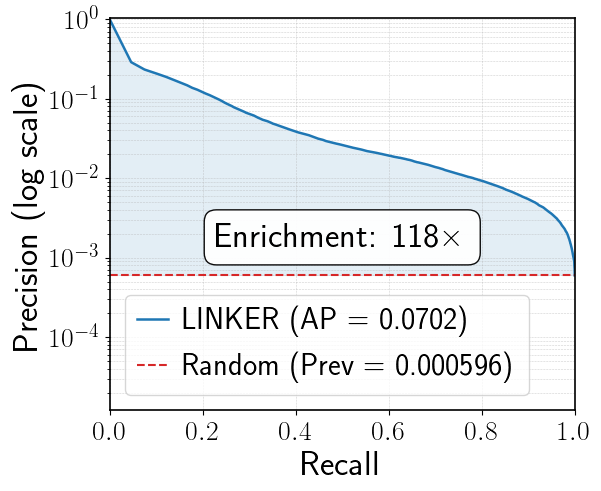

Saved /home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/pr_curve_compact_bindingdb_clean_font.pdf (0.24 MB)


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------
# Load metrics
# -------------------------
with open("/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/backup/metrics_micro_synthesis.pkl", "rb") as f:
    metrics = pickle.load(f)

precision = np.asarray(metrics["precision"])
recall = np.asarray(metrics["recall"])
aupr = float(metrics["aupr"])
y_true = np.asarray(metrics["y_true"])

# prevalence = expected PR-AUC for a random ranker
prevalence = float(np.mean(y_true))
fold_over = aupr / prevalence if prevalence > 0 else np.inf

# -------------------------
# Reduce points if necessary
# -------------------------
MAX_POINTS = 3000
n = len(recall)
if n > MAX_POINTS:
    idx = np.linspace(0, n - 1, MAX_POINTS).astype(int)
    recall_ds = recall[idx]
    precision_ds = precision[idx]
else:
    recall_ds = recall
    precision_ds = precision

# -------------------------
# rcParams (reasonable sizes)
# -------------------------
plt.rcParams.update({
    "figure.figsize": (6, 5.1),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  
    "font.size": 25,
    "axes.titlesize": 20,
    "axes.labelsize": 25,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 22,
    "axes.linewidth": 1.2
    # "pdf.compression": 5,
    # "pdf.fonttype": 42
})

# -------------------------
# Plot (no constrained_layout)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5.1))  # (width, height) inch

curve_color = "#1f77b4"
baseline_color = "#d62728"

# PR curve (vector)
ax.plot(recall_ds, precision_ds, color=curve_color, lw=1.8,
        label=f"LINKER (AP = {aupr:.4f})")

# Rasterize fill_between to reduce PDF size
ax.fill_between(recall_ds, precision_ds, prevalence,
                where=(precision_ds >= prevalence),
                interpolate=True, color=curve_color, alpha=0.12,
                linewidth=0, rasterized=True)

# Prevalence line (vector)
ax.hlines(prevalence, xmin=0.0, xmax=1.0, colors=baseline_color,
            linestyles="--", lw=1.5, label=f"Random (Prev = {prevalence:.6f})")

# Log scale for precision
ax.set_yscale("log")
ymin = max(prevalence / 50.0, 1e-8)
ax.set_ylim(ymin, 1.05)
ax.set_xlim(0.0, 1.0)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision (log scale)")

x_pos = 0.5
y_pos = np.median(precision_ds) * 0.5 + 0.002  # hơi thấp để nằm trong vùng xanh
enrichment_txt = f"Enrichment: {fold_over:.0f}×"
ax.text(x_pos, y_pos, enrichment_txt,
        ha="center", va="top",
        bbox=dict(boxstyle="round,pad=0.35",
                    facecolor="white", alpha=0.95, edgecolor="0.0"))

# Legend
ax.legend(loc="lower left",
    handlelength=1,      
    handletextpad=0.5,   
)

ax.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.6)

# tidy layout and save compact PDF (rasterized parts use dpi)
# plt.tight_layout()
out_pdf = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/pr_curve_compact_bindingdb_clean_font.pdf"
# fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
# plt.close(fig)
plt.show()
# report saved size
size_mb = os.path.getsize(out_pdf) / (1024 ** 2)
print(f"Saved {out_pdf} ({size_mb:.2f} MB)")


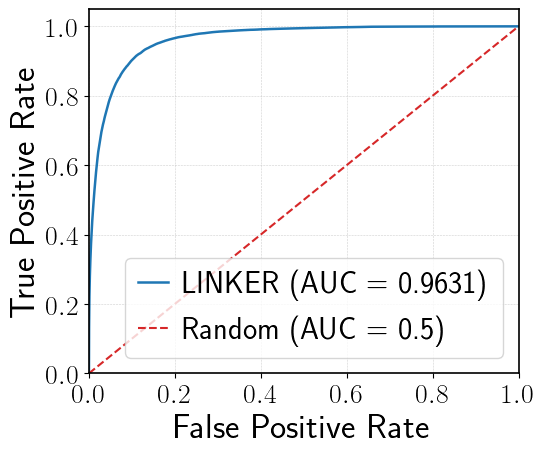

Saved /home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/roc_curve_compact_bindingdb_clean_font.pdf (0.09 MB)


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc

# -------------------------
# Load metrics
# -------------------------
with open("/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/backup/metrics_micro_synthesis.pkl", "rb") as f:
    metrics = pickle.load(f)

y_true = np.asarray(metrics["y_true"])
y_score = np.asarray(metrics["y_score"])   # cần có score để tính ROC

# -------------------------
# ROC metrics
# -------------------------
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# -------------------------
# Reduce points if necessary
# -------------------------
MAX_POINTS = 3000
n = len(fpr)
if n > MAX_POINTS:
    idx = np.linspace(0, n - 1, MAX_POINTS).astype(int)
    fpr_ds = fpr[idx]
    tpr_ds = tpr[idx]
else:
    fpr_ds = fpr
    tpr_ds = tpr

# -------------------------
# rcParams (same as PR curve)
# -------------------------
plt.rcParams.update({
    "figure.figsize": (6, 5.1),
    "text.usetex": True,             # bật LaTeX
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  
    "font.size": 25,
    "axes.titlesize": 20,
    "axes.labelsize": 25,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 22,
    "axes.linewidth": 1.2
    # "pdf.compression": 5,
    # "pdf.fonttype": 42
})

# -------------------------
# Plot (no constrained_layout)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5.1))  # (width, height) inch

curve_color = "#1f77b4"
baseline_color = "#d62728"

# ROC curve
ax.plot(fpr_ds, tpr_ds, color=curve_color, lw=1.8,
        label=f"LINKER (AUC = {roc_auc:.4f})")

# Baseline (random chance diagonal)
ax.plot([0, 1], [0, 1], linestyle="--", color=baseline_color, lw=1.5,
        label="Random (AUC = 0.5)")

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

# Legend
ax.legend(loc="lower right",
    handlelength=1,      # 🔥 không vẽ đường
    handletextpad=0.5,   # sát chữ
)

ax.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.6)

# Save figure
plt.tight_layout()
out_pdf = "/home/phuc.phamhuythienai@gmail.com/Desktop/ExplainabilityInteraction/src/evaluation/roc_curve_compact_bindingdb_clean_font.pdf"
# fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
# plt.close(fig)
plt.show()
size_mb = os.path.getsize(out_pdf) / (1024 ** 2)
print(f"Saved {out_pdf} ({size_mb:.2f} MB)")
